In [1]:
!pip install torch torchvision scikit-learn matplotlib ultralytics umap

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 91.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 71.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 34.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 73.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 34.7 MB/s eta 0:00:00
  Created wheel for umap: filename=umap-0.1.1-py3-none-any.whl size=3541 sha256=adc74

# Import Dataset

In [2]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="J1rWUvuwvKwOyLI5ooEK")
project = rf.workspace("sanjana-kazi-supti-ymhu2").project("final-1yr0d-wo5ot")
version = project.version(1)
dataset = version.download("coco")
                

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.6/88.6 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 44.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 48.1 MB/s eta 0:00:00
  Attempting uninstall: idna
    Found existing installation: idna 3.10
    Uninstalling idna-3.10:
      Successfully uninstalled idna-3.10
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.11.0.86
    Uninstalling opencv-python-headless-4.11.0.86:
      Successfully uninstalled opencv-python-headless-4.11.0.86
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.8.0 requires google-cloud-bigquery-storage<3.0.0,>=2.30.


Extracting Dataset Version Zip to Final-1 in coco:: 100%|██████████| 4295/4295 [00:01<00:00, 3479.05it/s]


# Fix the error in the json file

In [3]:
import json
from pathlib import Path

# ===== Path to your COCO dataset folder =====
dataset_dir = Path("/kaggle/working/Final-1")

# ===== Function to convert JSON to single-class =====
def convert_to_one_class(json_file):
    with open(json_file, "r") as f:
        coco_data = json.load(f)

    # Step 1: Keep only one category
    coco_data["categories"] = [{"id": 1, "name": "Sunflower"}]

    # Step 2: Remap all annotations to category_id = 1
    for ann in coco_data["annotations"]:
        ann["category_id"] = 1

    # Step 3: Save back (overwrite original)
    with open(json_file, "w") as f:
        json.dump(coco_data, f, indent=2)

    print(f"Converted: {json_file}")

# ===== Loop over train, valid, test annotation files =====
for split in ["train", "valid", "test"]:
    json_path = dataset_dir / split / "_annotations.coco.json"
    if json_path.exists():
        convert_to_one_class(json_path)
    else:
        print(f"⚠ No JSON file found for {split}")

print("All done! Update YAML with:")
print('nc: 1\nnames: ["Sunflower"]')


Converted: /kaggle/working/Final-1/train/_annotations.coco.json
Converted: /kaggle/working/Final-1/valid/_annotations.coco.json
Converted: /kaggle/working/Final-1/test/_annotations.coco.json
All done! Update YAML with:
nc: 1
names: ["Sunflower"]


# Setup

In [4]:
import os, json, yaml, math, gc, random, shutil, contextlib
from pathlib import Path
from PIL import Image

import torch, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from tqdm.auto import tqdm
from ultralytics import YOLO
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

device = "cuda" if torch.cuda.is_available() else "cpu"
torch.manual_seed(42)
print("Device:", device, "| torch", torch.__version__)

def autocast_ctx():
    return torch.autocast(device_type="cuda", enabled=True) if device=="cuda" else contextlib.nullcontext()

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Device: cuda | torch 2.6.0+cu124


# Path Declaration and COCO --> YOLO Conversion

In [5]:
import json
import shutil
import random
from pathlib import Path
import yaml
from ultralytics import YOLO

# ================================
# 1. Define Paths
# ================================
COCO_ROOT     =  Path("/kaggle/working/Final-1")  # folder with train/ and valid/
TRAIN_IMG_DIR = COCO_ROOT / "train"
TRAIN_ANN     = TRAIN_IMG_DIR / "_annotations.coco.json"
VAL_IMG_DIR   = COCO_ROOT / "valid"
VAL_ANN       = VAL_IMG_DIR / "_annotations.coco.json"

WORK          = Path("/kaggle/working/PSEUDO_STAC/Pseudo_Converted_Dataset")
SPLIT         = WORK / "0_yolo_split"       # YOLO-format dataset split
PSEUDO        = WORK / "1_pseudo"           # Pseudo-label storage
STU_ROOT      = WORK / "2_student"          # Student dataset (GT + pseudo)

# ================================
# 2. Create Folder Structure
# ================================
for split in ["train", "valid", "test"]:
    (SPLIT / split / "images").mkdir(parents=True, exist_ok=True)
    (SPLIT / split / "labels").mkdir(parents=True, exist_ok=True)

(PSEUDO / "raw").mkdir(parents=True, exist_ok=True)

for split in ["train", "valid"]:
    (STU_ROOT / split / "images").mkdir(parents=True, exist_ok=True)
    (STU_ROOT / split / "labels").mkdir(parents=True, exist_ok=True)

# ================================
# 3. Load Classes from COCO
# ================================
cats = json.load(open(TRAIN_ANN))["categories"]
names = [c["name"] for c in sorted(cats, key=lambda x: x["id"])]
nc = len(names)

# ================================
# 4. COCO → YOLO Conversion
# ================================
def coco2yolo(b, w, h):
    x, y, ww, hh = b
    return (x + ww / 2) / w, (y + hh / 2) / h, ww / w, hh / h

def convert_split(split, img_dir, ann_json):
    coco = json.load(open(ann_json))
    id2img = {img["id"]: img for img in coco["images"]}
    out_im = SPLIT / split / "images"
    out_lb = SPLIT / split / "labels"

    # Write YOLO label files
    for ann in coco["annotations"]:
        img = id2img[ann["image_id"]]
        w, h = img["width"], img["height"]
        yb = coco2yolo(ann["bbox"], w, h)
        cls = ann["category_id"] - 1
        p = out_lb / f"{Path(img['file_name']).stem}.txt"
        with open(p, "a") as f:
            f.write(f"{cls} " + " ".join(f"{v:.6f}" for v in yb) + "\n")

    # Copy images
    for img in coco["images"]:
        shutil.copy(Path(img_dir) / img["file_name"], out_im / img["file_name"])

convert_split("train", TRAIN_IMG_DIR, TRAIN_ANN)
convert_split("valid", VAL_IMG_DIR, VAL_ANN)
convert_split("test", TRAIN_IMG_DIR, TRAIN_ANN)  # Use train as test if no separate test set
print("COCO to YOLO conversion completed.")

COCO to YOLO conversion completed.


# Dataset splitting and directory setup for teacher-student training

In [6]:
# ================================
# 5. Split labeled/unlabeled data from 20% labeled portion
# ================================
LABELED_RATIO = 0.4
random.seed(42)

all_train_images = list((SPLIT / "train" / "images").glob("*.jpg"))
random.shuffle(all_train_images)

num_labeled = int(len(all_train_images) * LABELED_RATIO)
labeled_images = all_train_images[:num_labeled]
unlabeled_images = all_train_images[num_labeled:]

print(f"Total train images: {len(all_train_images)}")
print(f"Labeled images (20%): {len(labeled_images)}")
print(f"Unlabeled images (80%): {len(unlabeled_images)}")

# Further split labeled into train (90%) and val (10%)
val_ratio = 0.1
num_val = int(len(labeled_images) * val_ratio)
random.shuffle(labeled_images)
val_images = labeled_images[:num_val]
train_images_for_teacher = labeled_images[num_val:]

print(f"Teacher train images (90% of 20%): {len(train_images_for_teacher)}")
print(f"Teacher val images (10% of 20%): {len(val_images)}")

# Create directories
LABELED_TRAIN_IMG_DIR = WORK / "labeled_train" / "images"
LABELED_TRAIN_LB_DIR  = WORK / "labeled_train" / "labels"
LABELED_VAL_IMG_DIR   = WORK / "labeled_val" / "images"
LABELED_VAL_LB_DIR    = WORK / "labeled_val" / "labels"
UNLABELED_IMG_DIR     = WORK / "unlabeled" / "images"

for d in [LABELED_TRAIN_IMG_DIR, LABELED_TRAIN_LB_DIR, LABELED_VAL_IMG_DIR, LABELED_VAL_LB_DIR, UNLABELED_IMG_DIR]:
    d.mkdir(parents=True, exist_ok=True)

# Copy train images + labels
for img_path in train_images_for_teacher:
    shutil.copy(img_path, LABELED_TRAIN_IMG_DIR / img_path.name)
    label_path = SPLIT / "train" / "labels" / f"{img_path.stem}.txt"
    if label_path.exists():
        shutil.copy(label_path, LABELED_TRAIN_LB_DIR / label_path.name)

# Copy val images + labels
for img_path in val_images:
    shutil.copy(img_path, LABELED_VAL_IMG_DIR / img_path.name)
    label_path = SPLIT / "train" / "labels" / f"{img_path.stem}.txt"
    if label_path.exists():
        shutil.copy(label_path, LABELED_VAL_LB_DIR / label_path.name)

# Copy unlabeled images only
for img_path in unlabeled_images:
    shutil.copy(img_path, UNLABELED_IMG_DIR / img_path.name)

# Copy validation set (from original valid) to STU_ROOT for student eval
(STU_ROOT / "valid" / "images").mkdir(parents=True, exist_ok=True)
(STU_ROOT / "valid" / "labels").mkdir(parents=True, exist_ok=True)
for img in (SPLIT / "valid" / "images").glob("*.*"):
    shutil.copy(img, STU_ROOT / "valid" / "images" / img.name)
    lbl = SPLIT / "valid" / "labels" / f"{img.stem}.txt"
    if lbl.exists():
        shutil.copy(lbl, STU_ROOT / "valid" / "labels" / lbl.name)

# Copy teacher training set to STU_ROOT/train (needed for pseudo-label merging)
(STU_ROOT / "train" / "images").mkdir(parents=True, exist_ok=True)
(STU_ROOT / "train" / "labels").mkdir(parents=True, exist_ok=True)
for img_path in train_images_for_teacher:
    shutil.copy(img_path, STU_ROOT / "train" / "images" / img_path.name)
    label_path = SPLIT / "train" / "labels" / f"{img_path.stem}.txt"
    if label_path.exists():
        shutil.copy(label_path, STU_ROOT / "train" / "labels" / label_path.name)

print("Data splitting and copying done.")

Total train images: 3957
Labeled images (20%): 1582
Unlabeled images (80%): 2375
Teacher train images (90% of 20%): 1424
Teacher val images (10% of 20%): 158
Data splitting and copying done.


# Dataset YAML preparation for teacher–student pipeline

In [7]:
# ================================
# 6. Prepare YAML files
# ================================
teacher_data_yaml = {
    'path': str(WORK / "labeled_train"),
    'train': 'images',
    'val': str(LABELED_VAL_IMG_DIR),  # Use absolute path for val
    'nc': nc,
    'names': names
}
teacher_data_yaml_path = WORK / "teacher_data.yaml"
teacher_data_yaml_path.write_text(yaml.dump(teacher_data_yaml))

student_data_yaml = {
    'path': str(STU_ROOT),
    'train': 'train/images',
    'val': 'valid/images',
    'nc': nc,
    'names': names
}
student_data_yaml_path = WORK / "data_Sunflower_student.yaml"
student_data_yaml_path.write_text(yaml.dump(student_data_yaml))

print("YAML files prepared.")

YAML files prepared.


# Two-phase teacher training: freeze backbone, then unfreeze for fine-tuning

In [8]:
# ================================
# 7. Teacher training with frozen backbone then fine-tuning
# ================================

# Use pretrained YOLOv12s instead of local best.pt
teacher = YOLO("yolo12s.pt")  

# Freeze first 25% backbone layers
backbone = teacher.model.model[0]
backbone_layers = list(backbone.children())
total_layers = len(backbone_layers)
freeze_count = int(total_layers * 0.25)
for i, layer in enumerate(backbone_layers):
    if i < freeze_count:
        layer.eval()
        for param in layer.parameters():
            param.requires_grad = False
print(f"Frozen {freeze_count}/{total_layers} backbone layers.")

teacher.train(
    data=str(teacher_data_yaml_path),
    epochs=5,
    imgsz=640,
    batch=12,
    project=str(WORK),
    name="teacher_partial_freeze",
    device=0,
    lr0=0.001,
    lrf=0.1,
    momentum=0.937,
    weight_decay=0.0005,
    cos_lr=True,
    save=True,
)

# Unfreeze all layers for fine-tuning
for param in teacher.model.parameters():
    param.requires_grad = True
print("All layers unfrozen for fine-tuning.")

last_checkpoint = WORK / "teacher_partial_freeze" / "weights" / "last.pt"

teacher.train(
    data=str(teacher_data_yaml_path),
    epochs=50,
    imgsz=640,
    batch=12,
    project=str(WORK),
    name="teacher_final",
    device=0,
    lr0=0.0005,
    lrf=0.05,
    momentum=0.937,
    weight_decay=0.0005,
    cos_lr=True,
    save=True,
    resume=False,
    pretrained=str(last_checkpoint)  # load last checkpoint from frozen phase
)

teacher_weights = WORK / "teacher_final" / "weights" / "best.pt"
print(f"Teacher final model saved to {teacher_weights}")


Frozen 0/3 backbone layers.
Ultralytics 8.3.180 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=12, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=True, cutmix=0.0, data=/kaggle/working/PSEUDO_STAC/Pseudo_Converted_Dataset/teacher_data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.001, lrf=0.1, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo12s.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=teacher_partial_freeze, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, o

Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1       928  ultralytics.nn.modules.conv.Conv             [3, 32, 3, 2]                 
  1                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  2                  -1  1     26080  ultralytics.nn.modules.block.C3k2            [64, 128, 1, False, 0.25]     
  3                  -1  1    147712  ultralytics.nn.modules.conv.Conv             [128, 128, 3, 2]              
  4                  -1  1    103360  ultralytics.nn.modules.block.C3k2            [128, 256, 1, False, 0.25]    
  5                  -1  1    590336  ultralytics.nn.modules.conv.Conv             [256, 256, 3, 2]              
  6                  -1  2    689408  ultralytics.nn.modules.block.A2C2f           [256, 256, 2, True, 4]        
  7                  -1  1   1180672  ultralytics

AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1878.5±634.8 MB/s, size: 93.7 KB)


train: Scanning /kaggle/working/PSEUDO_STAC/Pseudo_Converted_Dataset/labeled_train/labels... 1424 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1424/1424 [00:01<00:00, 1054.75it/s]


train: New cache created: /kaggle/working/PSEUDO_STAC/Pseudo_Converted_Dataset/labeled_train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 445.5±50.6 MB/s, size: 87.7 KB)


val: Scanning /kaggle/working/PSEUDO_STAC/Pseudo_Converted_Dataset/labeled_val/labels... 158 images, 0 backgrounds, 0 corrupt: 100%|██████████| 158/158 [00:00<00:00, 804.60it/s] 

val: New cache created: /kaggle/working/PSEUDO_STAC/Pseudo_Converted_Dataset/labeled_val/labels.cache


Plotting labels to /kaggle/working/PSEUDO_STAC/Pseudo_Converted_Dataset/teacher_partial_freeze/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.001' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 113 weight(decay=0.0), 120 weight(decay=0.00046875), 119 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to /kaggle/working/PSEUDO_STAC/Pseudo_Converted_Dataset/teacher_partial_freeze
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      8.28G      1.724      1.134      1.187       1085        640: 100%|██████████| 119/119 [00:44<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.17it/s]

                   all        158      12424      0.747      0.734      0.779       0.42



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      7.03G      1.588      0.863        1.1       1105        640: 100%|██████████| 119/119 [00:42<00:00,  2.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.86it/s]

                   all        158      12424      0.812      0.771      0.853      0.471



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      7.09G      1.522     0.8147       1.07        636        640: 100%|██████████| 119/119 [00:42<00:00,  2.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.85it/s]

                   all        158      12424      0.816      0.786      0.868      0.488



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      7.12G      1.463     0.7697       1.05        647        640: 100%|██████████| 119/119 [00:42<00:00,  2.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.85it/s]

                   all        158      12424      0.826      0.806      0.882      0.511



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      7.15G      1.397     0.7335      1.032        810        640: 100%|██████████| 119/119 [00:43<00:00,  2.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.82it/s]

                   all        158      12424      0.829      0.816      0.891      0.533



5 epochs completed in 0.065 hours.
Optimizer stripped from /kaggle/working/PSEUDO_STAC/Pseudo_Converted_Dataset/teacher_partial_freeze/weights/last.pt, 18.9MB
Optimizer stripped from /kaggle/working/PSEUDO_STAC/Pseudo_Converted_Dataset/teacher_partial_freeze/weights/best.pt, 18.9MB

Validating /kaggle/working/PSEUDO_STAC/Pseudo_Converted_Dataset/teacher_partial_freeze/weights/best.pt...
Ultralytics 8.3.180 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLOv12s summary (fused): 159 layers, 9,231,267 parameters, 0 gradients, 21.2 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:10<00:00,  1.51s/it]
invalid value encountered in less
invalid value encountered in less


                   all        158      12424       0.83      0.816      0.891      0.533
Speed: 0.3ms preprocess, 8.6ms inference, 0.0ms loss, 13.1ms postprocess per image
Results saved to /kaggle/working/PSEUDO_STAC/Pseudo_Converted_Dataset/teacher_partial_freeze
All layers unfrozen for fine-tuning.
Transferred 691/691 items from pretrained weights
Ultralytics 8.3.180 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=12, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=True, cutmix=0.0, data=/kaggle/working/PSEUDO_STAC/Pseudo_Converted_Dataset/teacher_data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.01

train: Scanning /kaggle/working/PSEUDO_STAC/Pseudo_Converted_Dataset/labeled_train/labels.cache... 1424 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1424/1424 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 275.0±147.2 MB/s, size: 87.7 KB)


val: Scanning /kaggle/working/PSEUDO_STAC/Pseudo_Converted_Dataset/labeled_val/labels.cache... 158 images, 0 backgrounds, 0 corrupt: 100%|██████████| 158/158 [00:00<?, ?it/s]


Plotting labels to /kaggle/working/PSEUDO_STAC/Pseudo_Converted_Dataset/teacher_final/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.0005' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 113 weight(decay=0.0), 120 weight(decay=0.00046875), 119 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to /kaggle/working/PSEUDO_STAC/Pseudo_Converted_Dataset/teacher_final
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      8.33G      1.409     0.7311       1.03       1085        640: 100%|██████████| 119/119 [00:45<00:00,  2.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.76it/s]

                   all        158      12424      0.807       0.79      0.862      0.484



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      7.06G      1.466     0.7731      1.048       1105        640: 100%|██████████| 119/119 [00:44<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.78it/s]

                   all        158      12424      0.812      0.777      0.857      0.488



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50       7.1G      1.468     0.7898      1.045        636        640: 100%|██████████| 119/119 [00:44<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/7 [00:00<?, ?it/s]invalid value encountered in greater_equal
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.74it/s]

                   all        158      12424      0.227        0.8      0.205      0.118



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50       7.1G      1.466     0.7816      1.047        647        640: 100%|██████████| 119/119 [00:44<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.78it/s]

                   all        158      12424      0.813      0.802       0.87      0.486



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50       7.1G      1.463     0.7779      1.051        810        640: 100%|██████████| 119/119 [00:44<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.77it/s]

                   all        158      12424      0.798      0.811       0.87      0.485



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      7.14G      1.467     0.7728      1.044        859        640: 100%|██████████| 119/119 [00:44<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.80it/s]

                   all        158      12424      0.821      0.781      0.867      0.516



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      7.15G      1.447     0.7613       1.04        770        640: 100%|██████████| 119/119 [00:44<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.79it/s]

                   all        158      12424      0.828      0.789      0.869      0.486



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      7.17G      1.422     0.7452      1.032        994        640: 100%|██████████| 119/119 [00:44<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.81it/s]

                   all        158      12424      0.823      0.811      0.881      0.511



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      7.17G      1.427     0.7568      1.033        991        640: 100%|██████████| 119/119 [00:44<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.79it/s]

                   all        158      12424      0.826      0.804      0.883      0.536



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      7.17G      1.404     0.7375      1.022        631        640: 100%|██████████| 119/119 [00:44<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.80it/s]

                   all        158      12424      0.816      0.808      0.881      0.519



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      7.19G      1.409     0.7363      1.027       1359        640: 100%|██████████| 119/119 [00:44<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.83it/s]

                   all        158      12424      0.836       0.82      0.899      0.528



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      7.23G      1.394     0.7274      1.023        649        640: 100%|██████████| 119/119 [00:44<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.81it/s]

                   all        158      12424      0.837      0.802      0.885      0.521



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      7.27G      1.376     0.7216       1.02        817        640: 100%|██████████| 119/119 [00:44<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.77it/s]

                   all        158      12424      0.832      0.813       0.89      0.532



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      7.27G      1.365     0.7105       1.01        797        640: 100%|██████████| 119/119 [00:44<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.81it/s]

                   all        158      12424      0.847      0.818      0.902      0.535



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      7.27G      1.374     0.7137      1.009       1060        640: 100%|██████████| 119/119 [00:44<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.78it/s]

                   all        158      12424      0.841      0.824      0.903      0.541



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      7.27G      1.368     0.7032      1.004        945        640: 100%|██████████| 119/119 [00:44<00:00,  2.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.79it/s]

                   all        158      12424      0.836      0.819      0.896      0.533



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      7.27G      1.358     0.6957      1.014        599        640: 100%|██████████| 119/119 [00:44<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.78it/s]

                   all        158      12424      0.837      0.817      0.893       0.53



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      7.27G      1.346      0.693      1.001        604        640: 100%|██████████| 119/119 [00:44<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.77it/s]

                   all        158      12424       0.84      0.825      0.902       0.54



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      7.27G      1.349      0.685      1.001        722        640: 100%|██████████| 119/119 [00:44<00:00,  2.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.78it/s]

                   all        158      12424      0.837      0.818        0.9      0.557



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      7.27G      1.353     0.6953       1.01        791        640: 100%|██████████| 119/119 [00:44<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.77it/s]

                   all        158      12424      0.838      0.822      0.899      0.538



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      7.27G      1.318     0.6743     0.9932        930        640: 100%|██████████| 119/119 [00:44<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.79it/s]

                   all        158      12424      0.844      0.823      0.903      0.547



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      7.27G       1.33     0.6753     0.9967        690        640: 100%|██████████| 119/119 [00:44<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.77it/s]

                   all        158      12424      0.839      0.829      0.903      0.553



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      7.27G      1.326     0.6724     0.9957        844        640: 100%|██████████| 119/119 [00:44<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.78it/s]

                   all        158      12424      0.836      0.831      0.902      0.547



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      7.27G      1.307     0.6578     0.9883        601        640: 100%|██████████| 119/119 [00:44<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.81it/s]

                   all        158      12424      0.838      0.832      0.903      0.559



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      7.27G      1.306     0.6653     0.9938        913        640: 100%|██████████| 119/119 [00:44<00:00,  2.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.81it/s]

                   all        158      12424      0.852      0.832       0.91      0.557



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      7.27G      1.293     0.6482     0.9839       1044        640: 100%|██████████| 119/119 [00:44<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.80it/s]

                   all        158      12424      0.843      0.838      0.907      0.558



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      7.27G      1.289     0.6488     0.9831       1136        640: 100%|██████████| 119/119 [00:44<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.80it/s]

                   all        158      12424      0.848      0.835      0.911      0.566



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      7.27G      1.287     0.6472     0.9835       1000        640: 100%|██████████| 119/119 [00:44<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.82it/s]

                   all        158      12424      0.843      0.839      0.911      0.568



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      7.27G      1.282     0.6457     0.9837        569        640: 100%|██████████| 119/119 [00:44<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.82it/s]

                   all        158      12424      0.852       0.83      0.907      0.565



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      7.27G      1.277     0.6366     0.9805       1108        640: 100%|██████████| 119/119 [00:44<00:00,  2.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.81it/s]

                   all        158      12424      0.851      0.835       0.91       0.56



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      7.27G      1.265      0.632     0.9791        463        640: 100%|██████████| 119/119 [00:44<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.82it/s]

                   all        158      12424      0.855      0.833       0.91      0.566



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      7.27G      1.271     0.6335     0.9799        762        640: 100%|██████████| 119/119 [00:44<00:00,  2.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.81it/s]

                   all        158      12424      0.845      0.839      0.909      0.565



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      7.27G      1.255     0.6256     0.9751       1237        640: 100%|██████████| 119/119 [00:44<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.84it/s]

                   all        158      12424      0.856      0.833      0.912      0.573



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      7.27G      1.248     0.6191     0.9713        935        640: 100%|██████████| 119/119 [00:44<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.83it/s]

                   all        158      12424       0.85      0.842      0.912       0.57



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      7.27G      1.257     0.6206     0.9735       1033        640: 100%|██████████| 119/119 [00:44<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.85it/s]

                   all        158      12424      0.852      0.842      0.914      0.573



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      8.16G      1.236     0.6111     0.9664        824        640: 100%|██████████| 119/119 [00:44<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.82it/s]

                   all        158      12424      0.854      0.839      0.913      0.572



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      7.26G      1.237     0.6118     0.9713       1064        640: 100%|██████████| 119/119 [00:44<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.83it/s]

                   all        158      12424      0.858      0.842      0.915      0.579



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      8.13G      1.245     0.6118     0.9671        855        640: 100%|██████████| 119/119 [00:44<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.81it/s]

                   all        158      12424      0.855       0.84      0.912      0.578



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      7.38G      1.236     0.6095     0.9688        820        640: 100%|██████████| 119/119 [00:44<00:00,  2.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.82it/s]

                   all        158      12424       0.85      0.846      0.914      0.577



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      7.41G      1.233     0.6065     0.9653        771        640: 100%|██████████| 119/119 [00:44<00:00,  2.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.82it/s]

                   all        158      12424      0.853      0.844      0.915      0.575


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      5.09G      1.234     0.5999     0.9761        611        640: 100%|██████████| 119/119 [00:42<00:00,  2.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.79it/s]

                   all        158      12424      0.849      0.846      0.914      0.576



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      5.13G      1.219     0.5913      0.973        475        640: 100%|██████████| 119/119 [00:41<00:00,  2.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.83it/s]

                   all        158      12424      0.851      0.848      0.915      0.576



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      5.17G      1.209      0.583      0.969        420        640: 100%|██████████| 119/119 [00:41<00:00,  2.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.79it/s]

                   all        158      12424      0.852      0.847      0.914       0.58



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      5.21G      1.205     0.5821     0.9672        668        640: 100%|██████████| 119/119 [00:41<00:00,  2.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.84it/s]

                   all        158      12424       0.86      0.843      0.916      0.585



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      5.55G      1.206     0.5798     0.9667        855        640: 100%|██████████| 119/119 [00:41<00:00,  2.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.84it/s]

                   all        158      12424      0.856      0.846      0.918      0.584



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      5.58G      1.196     0.5778     0.9641        672        640: 100%|██████████| 119/119 [00:41<00:00,  2.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.84it/s]

                   all        158      12424       0.85      0.851      0.916      0.582



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      5.58G      1.193     0.5721     0.9629        636        640: 100%|██████████| 119/119 [00:41<00:00,  2.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.84it/s]

                   all        158      12424      0.851      0.849      0.917      0.585



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      5.58G      1.186     0.5691     0.9605        490        640: 100%|██████████| 119/119 [00:41<00:00,  2.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.83it/s]

                   all        158      12424      0.851      0.849      0.918      0.586



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      5.58G      1.183     0.5692      0.961        525        640: 100%|██████████| 119/119 [00:41<00:00,  2.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.82it/s]

                   all        158      12424      0.855      0.846      0.917      0.585



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      5.58G      1.185      0.569     0.9567        604        640: 100%|██████████| 119/119 [00:41<00:00,  2.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.85it/s]

                   all        158      12424      0.853      0.851      0.916      0.587



50 epochs completed in 0.654 hours.
Optimizer stripped from /kaggle/working/PSEUDO_STAC/Pseudo_Converted_Dataset/teacher_final/weights/last.pt, 18.9MB
Optimizer stripped from /kaggle/working/PSEUDO_STAC/Pseudo_Converted_Dataset/teacher_final/weights/best.pt, 18.9MB

Validating /kaggle/working/PSEUDO_STAC/Pseudo_Converted_Dataset/teacher_final/weights/best.pt...
Ultralytics 8.3.180 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLOv12s summary (fused): 159 layers, 9,231,267 parameters, 0 gradients, 21.2 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:10<00:00,  1.57s/it]
invalid value encountered in less
invalid value encountered in less


                   all        158      12424      0.854       0.85      0.916      0.587
Speed: 0.3ms preprocess, 21.7ms inference, 0.0ms loss, 3.3ms postprocess per image
Results saved to /kaggle/working/PSEUDO_STAC/Pseudo_Converted_Dataset/teacher_final
Teacher final model saved to /kaggle/working/PSEUDO_STAC/Pseudo_Converted_Dataset/teacher_final/weights/best.pt


# Training metrics and result plots for teacher YOLO model

Available columns: ['epoch', 'time', 'train/box_loss', 'train/cls_loss', 'train/dfl_loss', 'metrics/precision(B)', 'metrics/recall(B)', 'metrics/mAP50(B)', 'metrics/mAP50-95(B)', 'val/box_loss', 'val/cls_loss', 'val/dfl_loss', 'lr/pg0', 'lr/pg1', 'lr/pg2']


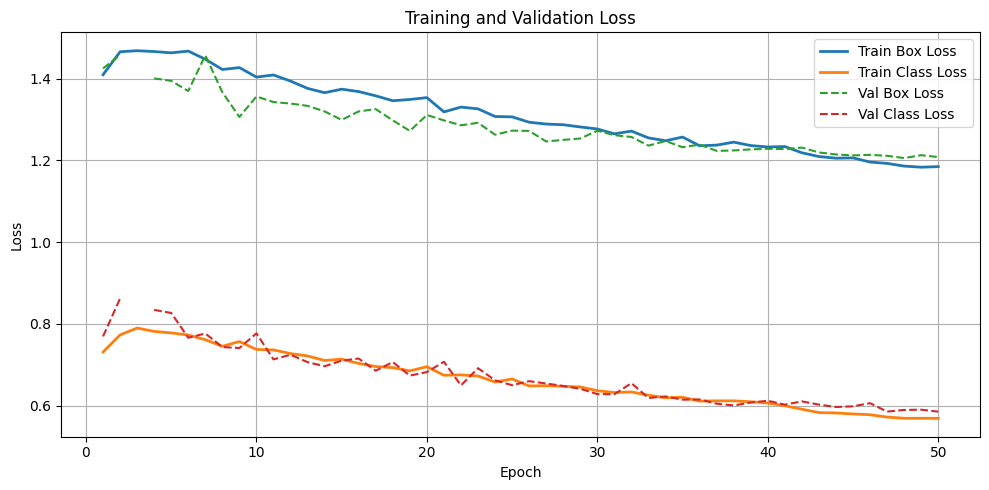

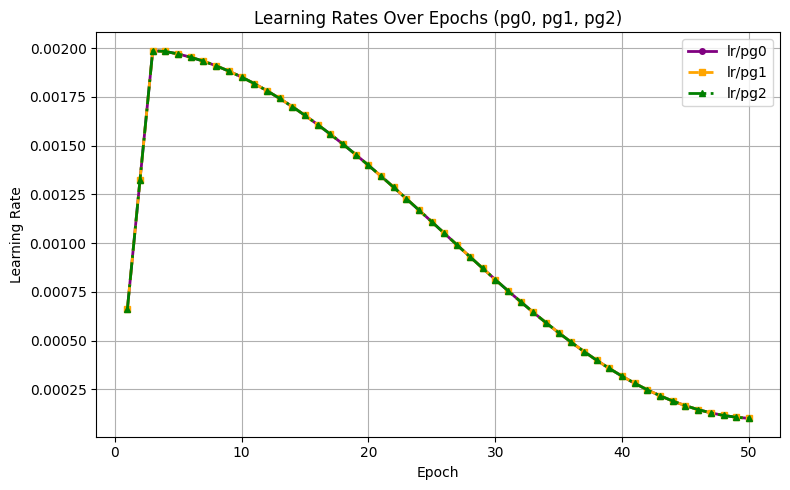

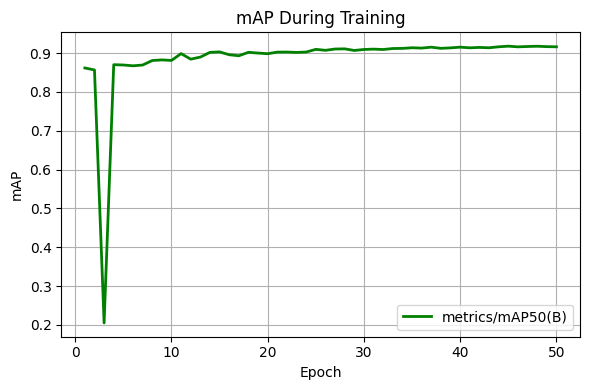

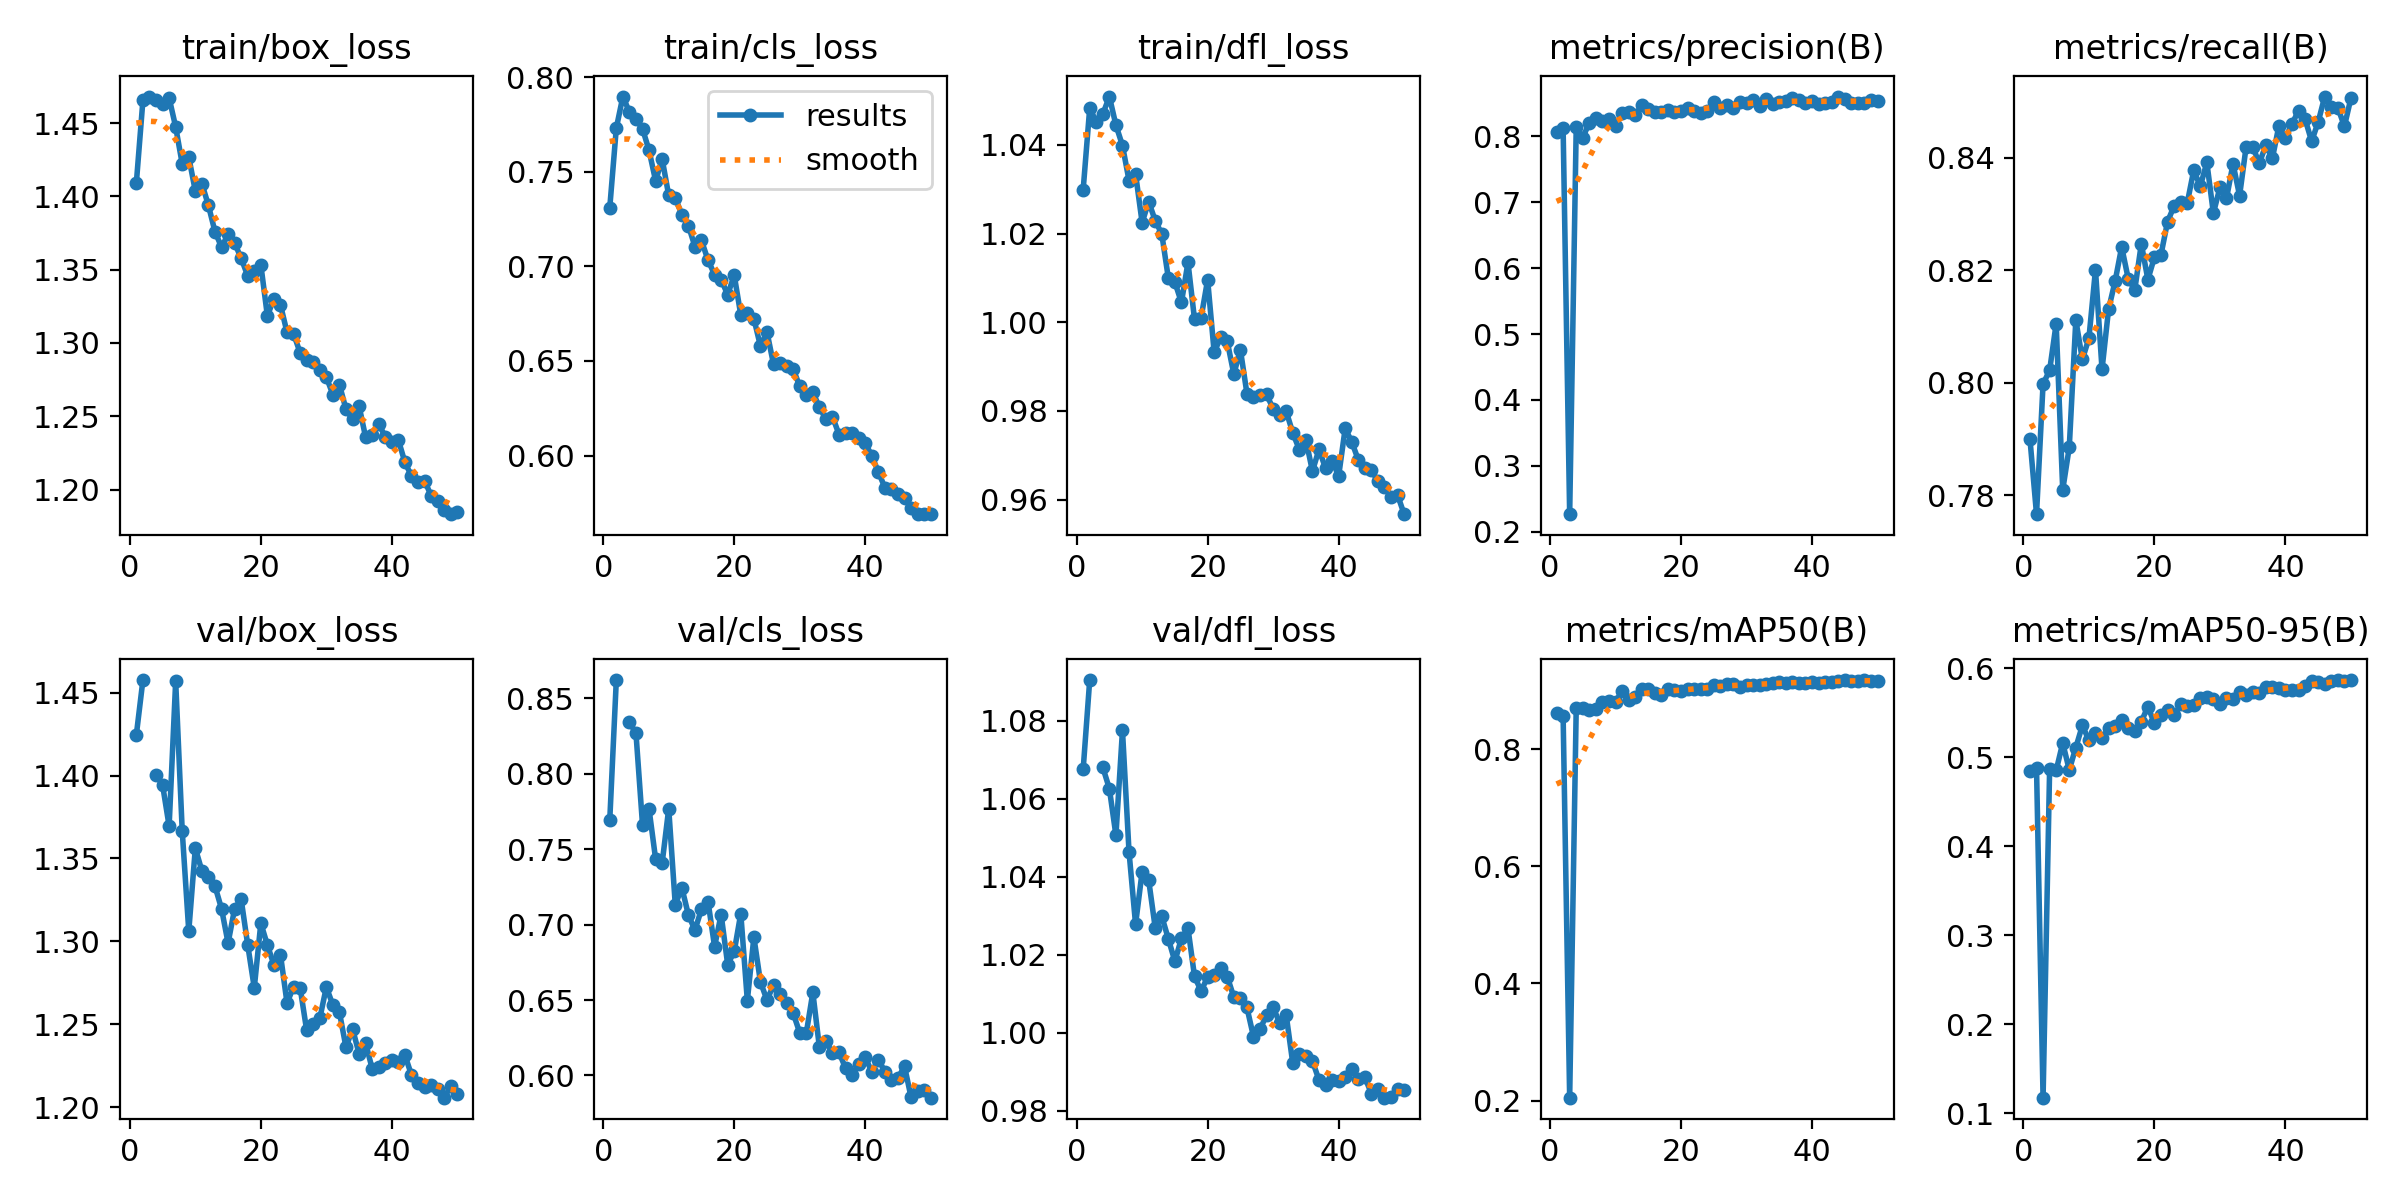

In [9]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path

# Path to results.csv
results_path = WORK / "teacher_final" / "results.csv"

# Load CSV
df = pd.read_csv(results_path)

# Show available columns
print("Available columns:", df.columns.tolist())

# Plot Loss Curves
plt.figure(figsize=(10, 5))
plt.plot(df["epoch"], df["train/box_loss"], label="Train Box Loss", linewidth=2)
plt.plot(df["epoch"], df["train/cls_loss"], label="Train Class Loss", linewidth=2)
plt.plot(df["epoch"], df["val/box_loss"], label="Val Box Loss", linestyle="--")
plt.plot(df["epoch"], df["val/cls_loss"], label="Val Class Loss", linestyle="--")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

lr_columns = [col for col in df.columns if col.startswith("lr/pg")]
colors = ['purple', 'orange', 'green']
styles = ['-', '--', '-.']
markers = ['o', 's', '^']

if lr_columns:
    plt.figure(figsize=(8, 5))
    for idx, col in enumerate(lr_columns):
        plt.plot(
            df["epoch"], df[col],
            label=col,
            color=colors[idx % len(colors)],
            linestyle=styles[idx % len(styles)],
            marker=markers[idx % len(markers)],
            markersize=4,
            linewidth=2
        )
    plt.xlabel("Epoch")
    plt.ylabel("Learning Rate")
    plt.title("Learning Rates Over Epochs (pg0, pg1, pg2)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
else:
    print("No learning rate columns found.")


# Plot mAP Curve (0.5 IoU)
map_keys = ["metrics/mAP50(B)", "metrics/mAP50-95(B)"]  # version dependent
map_column = next((key for key in map_keys if key in df.columns), None)

if map_column:
    plt.figure(figsize=(6, 4))
    plt.plot(df["epoch"], df[map_column], label=map_column, color="green", linewidth=2)
    plt.xlabel("Epoch")
    plt.ylabel("mAP")
    plt.title("mAP During Training")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()
else:
    print("mAP column not found. Skipping mAP plot.")



from PIL import Image
from IPython.display import display

results_img = WORK / "teacher_final" / "results.png"
img = Image.open(results_img)
display(img)

# Semi-supervised training using STAC: teacher generates pseudo-labels, student learns iteratively

In [10]:
# ================================
# 8. STAC-style self-training loop
# ================================
IMGZ = 640
TAU = 0.7
STAC_ITERS = 5
STU_EPOCHS = 50
BATCH = 12
DEVICE = "0"  # Change to "cpu" if no GPU available

print("Starting STAC self-training...")

for it in range(STAC_ITERS):
    print(f"\n=== STAC iteration {it+1}/{STAC_ITERS} ===")

    # 1. Generate pseudo-labels on UNLABELED images
    raw_label_dir = PSEUDO / "raw" / "labels"
    if raw_label_dir.exists():
        shutil.rmtree(raw_label_dir)
    raw_label_dir.mkdir(parents=True, exist_ok=True)

    print(f"Generating pseudo-labels on {len(list(UNLABELED_IMG_DIR.glob('*.*')))} unlabeled images...")
    YOLO(str(teacher_weights)).predict(
        source=str(UNLABELED_IMG_DIR),
        save_txt=True,
        save_conf=True,
        conf=TAU,
        project=str(PSEUDO),
        name="raw",
        device=DEVICE,
        imgsz=IMGZ,
        verbose=True,
    )

    # 2. Prepare student training labels by merging GT + pseudo labels
    labels_dir = STU_ROOT / "train" / "labels"
    # Clear existing student train labels
    for f in labels_dir.glob("*.txt"):
        f.unlink()

    # Copy ground-truth labels from labeled_train (teacher training GT)
    labeled_gt_dir = WORK / "labeled_train" / "labels"
    for gt_file in labeled_gt_dir.glob("*.txt"):
        shutil.copy(gt_file, labels_dir / gt_file.name)

        # If pseudo label exists for same image (only unlabeled images won't have GT)
        pseudo_file = raw_label_dir / gt_file.name
        if pseudo_file.exists():
            with open(labels_dir / gt_file.name, "a") as d, open(pseudo_file, "r") as p:
                d.write(p.read())

    # Add pseudo labels for unlabeled images (which have no GT)
    for pseudo_file in raw_label_dir.glob("*.txt"):
        if not (labels_dir / pseudo_file.name).exists():
            # This pseudo label corresponds to an unlabeled image
            # Copy it directly as student label
            shutil.copy(pseudo_file, labels_dir / pseudo_file.name)

    # Copy labeled + unlabeled images to STU_ROOT/train/images for student training
    # Clear previous images first
    images_dir = STU_ROOT / "train" / "images"
    for f in images_dir.glob("*.*"):
        f.unlink()

    # Copy labeled train images
    labeled_train_images = list((WORK / "labeled_train" / "images").glob("*.*"))
    for img in labeled_train_images:
        shutil.copy(img, images_dir / img.name)

    # Copy unlabeled images (pseudo-labeled) also
    unlabeled_images = list(UNLABELED_IMG_DIR.glob("*.*"))
    for img in unlabeled_images:
        shutil.copy(img, images_dir / img.name)

    print(f"Prepared training set: {len(list(images_dir.glob('*.*')))} images with merged labels.")

    # 3. Train student model on combined dataset
    student = YOLO(str(teacher_weights))
    student.train(
        data=str(WORK / "data_Sunflower_student.yaml"),  # your student YAML path
        epochs=STU_EPOCHS,
        imgsz=IMGZ,
        batch=BATCH,
        project=str(WORK),
        name=f"student_it{it+1}",
        device=DEVICE,
        verbose=True,
    )

    # 4. Update teacher weights to student's best weights for next iteration
    new_teacher_weights = WORK / f"student_it{it+1}" / "weights" / "best.pt"
    if not new_teacher_weights.exists():
        raise FileNotFoundError(f"Student weights not found: {new_teacher_weights}")
    teacher_weights = new_teacher_weights
    print(f"Teacher weights updated to iteration {it+1}'s student best weights.")

print("STAC self-training complete.")

Starting STAC self-training...

=== STAC iteration 1/5 ===
Generating pseudo-labels on 2375 unlabeled images...

WARNING ⚠️ 
inference results will accumulate in RAM unless `stream=True` is passed, causing potential out-of-memory
errors for large sources or long-running streams and videos. See https://docs.ultralytics.com/modes/predict/ for help.

Example:
    results = model(source=..., stream=True)  # generator of Results objects
    for r in results:
        boxes = r.boxes  # Boxes object for bbox outputs
        masks = r.masks  # Masks object for segment masks outputs
        probs = r.probs  # Class probabilities for classification outputs

image 1/2375 /kaggle/working/PSEUDO_STAC/Pseudo_Converted_Dataset/unlabeled/images/20240116_122814-mp4_frame11_jpg.rf.89dbffb6bc606c0c43f3f6083ba9dd86.jpg: 640x640 47 Sunflowers, 20.5ms
image 2/2375 /kaggle/working/PSEUDO_STAC/Pseudo_Converted_Dataset/unlabeled/images/20240116_122814-mp4_frame11_jpg.rf.d6a25166d65471f3fc9120c5a5b6c65e.jpg: 64

train: Scanning /kaggle/working/PSEUDO_STAC/Pseudo_Converted_Dataset/2_student/train/labels... 1424 images, 2375 backgrounds, 0 corrupt: 100%|██████████| 3799/3799 [00:02<00:00, 1664.94it/s]

train: New cache created: /kaggle/working/PSEUDO_STAC/Pseudo_Converted_Dataset/2_student/train/labels.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 344.6±173.7 MB/s, size: 96.9 KB)


val: Scanning /kaggle/working/PSEUDO_STAC/Pseudo_Converted_Dataset/2_student/valid/labels... 165 images, 0 backgrounds, 0 corrupt: 100%|██████████| 165/165 [00:00<00:00, 431.37it/s]

val: New cache created: /kaggle/working/PSEUDO_STAC/Pseudo_Converted_Dataset/2_student/valid/labels.cache


Plotting labels to /kaggle/working/PSEUDO_STAC/Pseudo_Converted_Dataset/student_it1/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 113 weight(decay=0.0), 120 weight(decay=0.00046875), 119 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to /kaggle/working/PSEUDO_STAC/Pseudo_Converted_Dataset/student_it1
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50       7.7G       1.26      1.407      0.971        194        640: 100%|██████████| 317/317 [01:53<00:00,  2.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.67it/s]

                   all        165      13823      0.844      0.829      0.897      0.527



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      5.97G      1.353      1.387      1.005        208        640: 100%|██████████| 317/317 [01:50<00:00,  2.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.64it/s]

                   all        165      13823      0.843      0.816      0.893      0.541



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      6.66G      1.382      1.397      1.021        386        640: 100%|██████████| 317/317 [01:50<00:00,  2.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.62it/s]

                   all        165      13823      0.797      0.811      0.859      0.496



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50       6.7G      1.394       1.41      1.023        149        640: 100%|██████████| 317/317 [01:50<00:00,  2.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.67it/s]

                   all        165      13823      0.831      0.812       0.88      0.515



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      6.72G      1.388      1.449      1.021         76        640: 100%|██████████| 317/317 [01:50<00:00,  2.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.65it/s]

                   all        165      13823      0.799      0.809      0.866      0.519



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      6.78G      1.381      1.391      1.011        311        640: 100%|██████████| 317/317 [01:50<00:00,  2.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.68it/s]

                   all        165      13823       0.85      0.781      0.874      0.517



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      6.82G      1.379       1.43      1.016        576        640: 100%|██████████| 317/317 [01:50<00:00,  2.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.67it/s]

                   all        165      13823      0.824      0.807      0.877      0.502



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      6.86G      1.375      1.398      1.011        187        640: 100%|██████████| 317/317 [01:50<00:00,  2.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.66it/s]

                   all        165      13823      0.838      0.812      0.889      0.516



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      6.89G      1.364      1.412      1.011        158        640: 100%|██████████| 317/317 [01:50<00:00,  2.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.68it/s]

                   all        165      13823      0.817      0.813      0.872      0.504



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      6.92G      1.364      1.413      1.007        205        640: 100%|██████████| 317/317 [01:50<00:00,  2.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.65it/s]

                   all        165      13823       0.84      0.807      0.885       0.51



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50       7.7G      1.351      1.368      1.002        125        640: 100%|██████████| 317/317 [01:51<00:00,  2.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.67it/s]

                   all        165      13823      0.833      0.812      0.885      0.532



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      6.01G      1.351      1.378      1.009        360        640: 100%|██████████| 317/317 [01:51<00:00,  2.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.63it/s]

                   all        165      13823      0.833      0.821       0.89      0.525



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      6.01G      1.328      1.379      1.003        233        640: 100%|██████████| 317/317 [01:50<00:00,  2.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.68it/s]

                   all        165      13823      0.852      0.826      0.902       0.55



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      6.01G      1.332      1.371      1.004        319        640: 100%|██████████| 317/317 [01:51<00:00,  2.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.68it/s]

                   all        165      13823      0.843      0.797      0.877      0.524



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      6.72G      1.338      1.386      1.004        142        640: 100%|██████████| 317/317 [01:51<00:00,  2.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.66it/s]

                   all        165      13823      0.809      0.828       0.88      0.513



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      6.77G      1.327      1.369     0.9974         85        640: 100%|██████████| 317/317 [01:51<00:00,  2.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.66it/s]

                   all        165      13823      0.809      0.836      0.885      0.533



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50       6.8G      1.322      1.364     0.9937         52        640: 100%|██████████| 317/317 [01:51<00:00,  2.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.65it/s]

                   all        165      13823      0.832      0.817      0.886      0.545



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      6.84G      1.319      1.353     0.9951        440        640: 100%|██████████| 317/317 [01:51<00:00,  2.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.67it/s]

                   all        165      13823      0.831       0.83       0.89      0.525



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      6.88G      1.312      1.359     0.9979        241        640: 100%|██████████| 317/317 [01:51<00:00,  2.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.68it/s]

                   all        165      13823      0.863      0.801      0.895       0.55



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      6.91G      1.309      1.355     0.9882        302        640: 100%|██████████| 317/317 [01:51<00:00,  2.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.63it/s]

                   all        165      13823      0.845      0.826      0.896      0.558



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50       7.7G      1.297      1.347     0.9872        172        640: 100%|██████████| 317/317 [01:50<00:00,  2.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.67it/s]

                   all        165      13823      0.818      0.841      0.883      0.542



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      6.42G      1.292      1.353     0.9819        173        640: 100%|██████████| 317/317 [01:50<00:00,  2.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.63it/s]

                   all        165      13823      0.851      0.823      0.899      0.563



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      6.42G      1.281      1.332     0.9798        183        640: 100%|██████████| 317/317 [01:50<00:00,  2.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.68it/s]

                   all        165      13823      0.842      0.834      0.898      0.551



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      6.42G      1.297       1.34     0.9826        196        640: 100%|██████████| 317/317 [01:50<00:00,  2.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.67it/s]

                   all        165      13823      0.834       0.83      0.893      0.552



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      6.42G      1.279      1.351     0.9841        782        640: 100%|██████████| 317/317 [01:50<00:00,  2.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.68it/s]

                   all        165      13823      0.853      0.814      0.899      0.552



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      6.46G      1.277      1.331     0.9787        284        640: 100%|██████████| 317/317 [01:50<00:00,  2.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.67it/s]

                   all        165      13823      0.836      0.842      0.896      0.554



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50       6.5G      1.276      1.334     0.9789        109        640: 100%|██████████| 317/317 [01:50<00:00,  2.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.68it/s]

                   all        165      13823      0.846      0.835        0.9      0.559



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      6.54G      1.266      1.313     0.9832        182        640: 100%|██████████| 317/317 [01:50<00:00,  2.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.68it/s]

                   all        165      13823      0.848      0.821      0.897      0.557



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      6.58G      1.261      1.327     0.9777        347        640: 100%|██████████| 317/317 [01:51<00:00,  2.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.57it/s]

                   all        165      13823      0.844      0.834      0.895      0.552



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      6.61G      1.256      1.306     0.9776        298        640: 100%|██████████| 317/317 [01:50<00:00,  2.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.67it/s]

                   all        165      13823      0.845      0.836      0.903      0.557



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      6.66G      1.263      1.339     0.9755        249        640: 100%|██████████| 317/317 [01:50<00:00,  2.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.69it/s]

                   all        165      13823      0.832      0.823      0.869      0.533



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      7.49G      1.257      1.315      0.975        169        640: 100%|██████████| 317/317 [01:50<00:00,  2.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.69it/s]

                   all        165      13823      0.838      0.831      0.891      0.546



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      6.14G      1.242      1.288     0.9646        183        640: 100%|██████████| 317/317 [01:50<00:00,  2.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.67it/s]

                   all        165      13823      0.833       0.84      0.893       0.54



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      6.14G      1.245      1.303     0.9724        314        640: 100%|██████████| 317/317 [01:50<00:00,  2.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.65it/s]

                   all        165      13823      0.849      0.828      0.894      0.555



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      6.79G      1.244      1.301     0.9735        537        640: 100%|██████████| 317/317 [01:50<00:00,  2.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.68it/s]

                   all        165      13823      0.822       0.84      0.882      0.538



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50       6.8G      1.241      1.349     0.9673        111        640: 100%|██████████| 317/317 [01:50<00:00,  2.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.68it/s]

                   all        165      13823      0.827      0.839       0.89      0.536



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      7.62G      1.232      1.317     0.9684        322        640: 100%|██████████| 317/317 [01:50<00:00,  2.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.67it/s]

                   all        165      13823      0.838      0.832      0.882      0.543



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      6.03G      1.221      1.312     0.9619        444        640: 100%|██████████| 317/317 [01:50<00:00,  2.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.69it/s]

                   all        165      13823      0.832      0.848      0.887      0.547



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      6.73G      1.223       1.28     0.9602        182        640: 100%|██████████| 317/317 [01:50<00:00,  2.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.68it/s]

                   all        165      13823      0.831      0.841       0.88       0.54



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      6.76G      1.221      1.268     0.9627        440        640: 100%|██████████| 317/317 [01:50<00:00,  2.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.69it/s]

                   all        165      13823      0.832      0.843      0.882      0.545


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      6.81G      1.222      1.378     0.9776        165        640: 100%|██████████| 317/317 [01:49<00:00,  2.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.65it/s]

                   all        165      13823      0.826      0.843      0.883      0.538



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      6.85G      1.211      3.034      0.971        201        640: 100%|██████████| 317/317 [01:48<00:00,  2.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.69it/s]

                   all        165      13823      0.825      0.838      0.872      0.533



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      6.89G      1.191      7.198     0.9648         18        640: 100%|██████████| 317/317 [01:48<00:00,  2.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.64it/s]

                   all        165      13823       0.82      0.837      0.858      0.524



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      6.93G      1.193      3.263     0.9638         61        640: 100%|██████████| 317/317 [01:49<00:00,  2.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.70it/s]

                   all        165      13823      0.797      0.829      0.853       0.51



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      6.95G      1.196      1.298     0.9664        378        640: 100%|██████████| 317/317 [01:48<00:00,  2.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.69it/s]

                   all        165      13823      0.808      0.826      0.852       0.51



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50         7G      1.184      5.739     0.9608         22        640: 100%|██████████| 317/317 [01:48<00:00,  2.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.71it/s]

                   all        165      13823      0.802      0.832      0.861      0.524



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      7.04G      1.183      3.957      0.961        217        640: 100%|██████████| 317/317 [01:48<00:00,  2.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.69it/s]

                   all        165      13823      0.798      0.819      0.861      0.523



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      7.08G      1.187      1.279     0.9638        195        640: 100%|██████████| 317/317 [01:48<00:00,  2.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.63it/s]

                   all        165      13823       0.78      0.786      0.827      0.498



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      7.12G      1.171      5.584     0.9539         11        640: 100%|██████████| 317/317 [01:48<00:00,  2.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.68it/s]

                   all        165      13823      0.783      0.797      0.839      0.512



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      7.14G      1.172      1.234     0.9584         75        640: 100%|██████████| 317/317 [01:48<00:00,  2.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.68it/s]

                   all        165      13823      0.781      0.783      0.829      0.503



50 epochs completed in 1.580 hours.
Optimizer stripped from /kaggle/working/PSEUDO_STAC/Pseudo_Converted_Dataset/student_it1/weights/last.pt, 18.9MB
Optimizer stripped from /kaggle/working/PSEUDO_STAC/Pseudo_Converted_Dataset/student_it1/weights/best.pt, 18.9MB

Validating /kaggle/working/PSEUDO_STAC/Pseudo_Converted_Dataset/student_it1/weights/best.pt...
Ultralytics 8.3.180 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLOv12s summary (fused): 159 layers, 9,231,267 parameters, 0 gradients, 21.2 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:08<00:00,  1.18s/it]
invalid value encountered in less
invalid value encountered in less


                   all        165      13823       0.85      0.823      0.899      0.563
Speed: 0.2ms preprocess, 16.1ms inference, 0.0ms loss, 14.4ms postprocess per image
Results saved to /kaggle/working/PSEUDO_STAC/Pseudo_Converted_Dataset/student_it1
Teacher weights updated to iteration 1's student best weights.

=== STAC iteration 2/5 ===
Generating pseudo-labels on 2375 unlabeled images...

WARNING ⚠️ 
inference results will accumulate in RAM unless `stream=True` is passed, causing potential out-of-memory
errors for large sources or long-running streams and videos. See https://docs.ultralytics.com/modes/predict/ for help.

Example:
    results = model(source=..., stream=True)  # generator of Results objects
    for r in results:
        boxes = r.boxes  # Boxes object for bbox outputs
        masks = r.masks  # Masks object for segment masks outputs
        probs = r.probs  # Class probabilities for classification outputs

image 1/2375 /kaggle/working/PSEUDO_STAC/Pseudo_Converted

train: Scanning /kaggle/working/PSEUDO_STAC/Pseudo_Converted_Dataset/2_student/train/labels.cache... 1424 images, 2375 backgrounds, 0 corrupt: 100%|██████████| 3799/3799 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 402.7±41.3 MB/s, size: 96.9 KB)


val: Scanning /kaggle/working/PSEUDO_STAC/Pseudo_Converted_Dataset/2_student/valid/labels.cache... 165 images, 0 backgrounds, 0 corrupt: 100%|██████████| 165/165 [00:00<?, ?it/s]


Plotting labels to /kaggle/working/PSEUDO_STAC/Pseudo_Converted_Dataset/student_it2/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 113 weight(decay=0.0), 120 weight(decay=0.00046875), 119 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to /kaggle/working/PSEUDO_STAC/Pseudo_Converted_Dataset/student_it2
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      7.89G      1.257      1.303     0.9694        194        640: 100%|██████████| 317/317 [01:56<00:00,  2.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.64it/s]

                   all        165      13823       0.84      0.829      0.897      0.552



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      6.06G       1.28      1.331     0.9795        208        640: 100%|██████████| 317/317 [01:52<00:00,  2.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.60it/s]

                   all        165      13823      0.813      0.839      0.883      0.536



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      6.69G      1.299      1.337     0.9897        386        640: 100%|██████████| 317/317 [01:51<00:00,  2.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.64it/s]

                   all        165      13823      0.817       0.83      0.876      0.515



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      6.69G       1.32      1.356     0.9964        149        640: 100%|██████████| 317/317 [01:51<00:00,  2.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.66it/s]

                   all        165      13823      0.829      0.825      0.889      0.513



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      6.69G      1.306      1.385     0.9928         76        640: 100%|██████████| 317/317 [01:51<00:00,  2.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.65it/s]

                   all        165      13823      0.838      0.809      0.883      0.547



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      6.69G      1.304      1.336     0.9879        311        640: 100%|██████████| 317/317 [01:51<00:00,  2.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.66it/s]

                   all        165      13823       0.85      0.796      0.884      0.536



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      6.69G      1.309      1.379     0.9902        576        640: 100%|██████████| 317/317 [01:51<00:00,  2.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.67it/s]

                   all        165      13823      0.827      0.833      0.891       0.52



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      6.69G      1.307      1.363     0.9869        187        640: 100%|██████████| 317/317 [01:50<00:00,  2.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.66it/s]

                   all        165      13823      0.852      0.819      0.899      0.544



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      6.69G      1.302      1.373     0.9867        158        640: 100%|██████████| 317/317 [01:51<00:00,  2.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.64it/s]

                   all        165      13823      0.842      0.819      0.888      0.536



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      6.69G      1.304       1.37     0.9869        205        640: 100%|██████████| 317/317 [01:51<00:00,  2.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.65it/s]

                   all        165      13823      0.834      0.818      0.879      0.515



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      7.42G      1.293      1.329     0.9806        125        640: 100%|██████████| 317/317 [01:51<00:00,  2.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.64it/s]

                   all        165      13823      0.839      0.824       0.89      0.543



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      6.16G        1.3       1.34     0.9874        360        640: 100%|██████████| 317/317 [01:51<00:00,  2.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.68it/s]

                   all        165      13823      0.833      0.816      0.883       0.54



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      6.16G      1.274      1.343     0.9822        233        640: 100%|██████████| 317/317 [01:50<00:00,  2.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.67it/s]

                   all        165      13823      0.843      0.826      0.892      0.554



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      6.16G       1.28      1.333     0.9831        319        640: 100%|██████████| 317/317 [01:50<00:00,  2.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.68it/s]

                   all        165      13823      0.848      0.808      0.885      0.541



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      6.16G      1.282      1.345     0.9847        142        640: 100%|██████████| 317/317 [01:50<00:00,  2.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.67it/s]

                   all        165      13823      0.824      0.834      0.881       0.52



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      6.16G      1.274      1.331     0.9815         85        640: 100%|██████████| 317/317 [01:51<00:00,  2.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.67it/s]

                   all        165      13823      0.812      0.836      0.863      0.516



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      6.16G      1.269      1.327     0.9742         52        640: 100%|██████████| 317/317 [01:51<00:00,  2.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.67it/s]

                   all        165      13823      0.834      0.828      0.877      0.537



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      6.16G      1.269      1.318     0.9789        440        640: 100%|██████████| 317/317 [01:50<00:00,  2.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.67it/s]

                   all        165      13823       0.84       0.83      0.885      0.533



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      6.19G      1.266      1.325     0.9811        241        640: 100%|██████████| 317/317 [01:51<00:00,  2.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.68it/s]

                   all        165      13823      0.848      0.823      0.888       0.54



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      6.19G      1.261      1.316     0.9712        302        640: 100%|██████████| 317/317 [01:51<00:00,  2.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.65it/s]

                   all        165      13823      0.836      0.828      0.884      0.546



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      6.93G      1.254       1.31     0.9747        172        640: 100%|██████████| 317/317 [01:50<00:00,  2.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.67it/s]

                   all        165      13823      0.794      0.852      0.856      0.513



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      6.93G      1.253      1.318     0.9691        173        640: 100%|██████████| 317/317 [01:51<00:00,  2.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.68it/s]

                   all        165      13823      0.842      0.817      0.885      0.544



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      6.93G      1.251      1.304     0.9701        183        640: 100%|██████████| 317/317 [01:51<00:00,  2.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.68it/s]

                   all        165      13823      0.842      0.828      0.889      0.549



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      6.93G      1.266      1.309     0.9728        196        640: 100%|██████████| 317/317 [01:51<00:00,  2.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.67it/s]

                   all        165      13823      0.839      0.832       0.89      0.544



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      6.93G      1.252      1.319     0.9755        782        640: 100%|██████████| 317/317 [01:51<00:00,  2.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.66it/s]

                   all        165      13823      0.849      0.816      0.887      0.536



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      6.93G      1.252      1.302     0.9705        284        640: 100%|██████████| 317/317 [01:51<00:00,  2.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.68it/s]

                   all        165      13823      0.835      0.831      0.881      0.544



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      6.93G      1.248      1.308     0.9688        109        640: 100%|██████████| 317/317 [01:51<00:00,  2.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.67it/s]

                   all        165      13823      0.834      0.844      0.896      0.552



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      6.93G       1.24       1.28     0.9719        182        640: 100%|██████████| 317/317 [01:51<00:00,  2.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.68it/s]

                   all        165      13823      0.831      0.832      0.877       0.53



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      6.93G      1.243      1.296     0.9704        347        640: 100%|██████████| 317/317 [01:51<00:00,  2.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.67it/s]

                   all        165      13823      0.843      0.836      0.885      0.548



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      6.93G      1.235      1.279     0.9684        298        640: 100%|██████████| 317/317 [01:51<00:00,  2.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.67it/s]

                   all        165      13823      0.826      0.842       0.88      0.538



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      6.93G      1.242      1.302     0.9692        249        640: 100%|██████████| 317/317 [01:51<00:00,  2.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.64it/s]

                   all        165      13823      0.815      0.826      0.842      0.511



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      7.72G      1.237      1.282     0.9675        169        640: 100%|██████████| 317/317 [01:51<00:00,  2.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.64it/s]

                   all        165      13823      0.834      0.837      0.881      0.538



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      6.09G       1.22      1.247     0.9569        183        640: 100%|██████████| 317/317 [01:51<00:00,  2.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.69it/s]

                   all        165      13823      0.794      0.841      0.867      0.523



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      6.09G      1.226       1.27     0.9655        314        640: 100%|██████████| 317/317 [01:51<00:00,  2.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.69it/s]

                   all        165      13823      0.833      0.825      0.872      0.536



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      6.74G      1.225      1.266     0.9651        537        640: 100%|██████████| 317/317 [01:50<00:00,  2.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.67it/s]

                   all        165      13823      0.799      0.845      0.862      0.523



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      6.77G      1.223      1.312     0.9595        111        640: 100%|██████████| 317/317 [01:51<00:00,  2.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.68it/s]

                   all        165      13823      0.823      0.834      0.882      0.532



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      7.55G      1.217      1.275     0.9614        322        640: 100%|██████████| 317/317 [01:51<00:00,  2.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.68it/s]

                   all        165      13823       0.83      0.827      0.869      0.531



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      6.07G      1.205      1.273     0.9555        444        640: 100%|██████████| 317/317 [01:51<00:00,  2.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.68it/s]

                   all        165      13823       0.81      0.852      0.869       0.53



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      6.75G       1.21      1.237     0.9541        182        640: 100%|██████████| 317/317 [01:51<00:00,  2.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.69it/s]

                   all        165      13823        0.8       0.83      0.858       0.52



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      6.75G       1.21      1.225     0.9574        440        640: 100%|██████████| 317/317 [01:51<00:00,  2.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.67it/s]

                   all        165      13823      0.787      0.837      0.853      0.525


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      6.75G       1.21      1.313     0.9723        165        640: 100%|██████████| 317/317 [01:50<00:00,  2.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.66it/s]

                   all        165      13823      0.787      0.838      0.859      0.521



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      6.75G        1.2      3.045     0.9644        201        640: 100%|██████████| 317/317 [01:49<00:00,  2.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.68it/s]

                   all        165      13823      0.812      0.785      0.852      0.516



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      6.75G      1.182       6.68     0.9584         18        640: 100%|██████████| 317/317 [01:48<00:00,  2.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.68it/s]

                   all        165      13823      0.772      0.821      0.836      0.501



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      6.75G      1.184      2.985     0.9584         61        640: 100%|██████████| 317/317 [01:48<00:00,  2.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.62it/s]

                   all        165      13823       0.76      0.809      0.828      0.496



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      6.77G      1.185      1.214     0.9605        378        640: 100%|██████████| 317/317 [01:48<00:00,  2.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.66it/s]

                   all        165      13823      0.748      0.754      0.805       0.48



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      6.77G      1.175      5.344     0.9556         22        640: 100%|██████████| 317/317 [01:48<00:00,  2.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.68it/s]

                   all        165      13823       0.77      0.826      0.842      0.509



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      6.77G      1.174      3.624     0.9566        217        640: 100%|██████████| 317/317 [01:48<00:00,  2.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.68it/s]

                   all        165      13823      0.776      0.793      0.839      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      6.78G       1.18      1.194     0.9605        195        640: 100%|██████████| 317/317 [01:48<00:00,  2.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.68it/s]

                   all        165      13823      0.763      0.773      0.825        0.5



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      6.78G      1.166      5.453      0.951         11        640: 100%|██████████| 317/317 [01:48<00:00,  2.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.64it/s]

                   all        165      13823      0.751      0.756      0.819      0.497



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      6.78G      1.168      1.148     0.9562         75        640: 100%|██████████| 317/317 [01:48<00:00,  2.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.67it/s]

                   all        165      13823      0.757      0.762       0.82      0.497



50 epochs completed in 1.585 hours.
Optimizer stripped from /kaggle/working/PSEUDO_STAC/Pseudo_Converted_Dataset/student_it2/weights/last.pt, 18.9MB
Optimizer stripped from /kaggle/working/PSEUDO_STAC/Pseudo_Converted_Dataset/student_it2/weights/best.pt, 18.9MB

Validating /kaggle/working/PSEUDO_STAC/Pseudo_Converted_Dataset/student_it2/weights/best.pt...
Ultralytics 8.3.180 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLOv12s summary (fused): 159 layers, 9,231,267 parameters, 0 gradients, 21.2 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:06<00:00,  1.01it/s]
invalid value encountered in less
invalid value encountered in less


                   all        165      13823      0.843      0.826      0.892      0.554
Speed: 0.3ms preprocess, 13.0ms inference, 0.0ms loss, 21.2ms postprocess per image
Results saved to /kaggle/working/PSEUDO_STAC/Pseudo_Converted_Dataset/student_it2
Teacher weights updated to iteration 2's student best weights.

=== STAC iteration 3/5 ===
Generating pseudo-labels on 2375 unlabeled images...

WARNING ⚠️ 
inference results will accumulate in RAM unless `stream=True` is passed, causing potential out-of-memory
errors for large sources or long-running streams and videos. See https://docs.ultralytics.com/modes/predict/ for help.

Example:
    results = model(source=..., stream=True)  # generator of Results objects
    for r in results:
        boxes = r.boxes  # Boxes object for bbox outputs
        masks = r.masks  # Masks object for segment masks outputs
        probs = r.probs  # Class probabilities for classification outputs

image 1/2375 /kaggle/working/PSEUDO_STAC/Pseudo_Converted

train: Scanning /kaggle/working/PSEUDO_STAC/Pseudo_Converted_Dataset/2_student/train/labels.cache... 1424 images, 2375 backgrounds, 0 corrupt: 100%|██████████| 3799/3799 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 353.6±187.6 MB/s, size: 96.9 KB)


val: Scanning /kaggle/working/PSEUDO_STAC/Pseudo_Converted_Dataset/2_student/valid/labels.cache... 165 images, 0 backgrounds, 0 corrupt: 100%|██████████| 165/165 [00:00<?, ?it/s]


Plotting labels to /kaggle/working/PSEUDO_STAC/Pseudo_Converted_Dataset/student_it3/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 113 weight(decay=0.0), 120 weight(decay=0.00046875), 119 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to /kaggle/working/PSEUDO_STAC/Pseudo_Converted_Dataset/student_it3
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      7.79G      1.243      1.292     0.9666        194        640: 100%|██████████| 317/317 [01:55<00:00,  2.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.65it/s]

                   all        165      13823      0.841      0.831       0.89       0.55



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      5.96G       1.25      1.307     0.9694        208        640: 100%|██████████| 317/317 [01:52<00:00,  2.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.69it/s]

                   all        165      13823       0.82      0.839      0.882      0.538



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      6.63G      1.264      1.312     0.9776        386        640: 100%|██████████| 317/317 [01:51<00:00,  2.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.65it/s]

                   all        165      13823      0.835      0.829      0.884      0.538



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      6.65G      1.275      1.328     0.9798        149        640: 100%|██████████| 317/317 [01:51<00:00,  2.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.68it/s]

                   all        165      13823      0.839      0.819      0.887      0.524



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      6.67G      1.272      1.358     0.9817         76        640: 100%|██████████| 317/317 [01:51<00:00,  2.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.69it/s]

                   all        165      13823       0.83      0.821      0.884      0.535



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      6.67G      1.274      1.306     0.9776        311        640: 100%|██████████| 317/317 [01:51<00:00,  2.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.68it/s]

                   all        165      13823      0.837      0.809      0.874      0.511



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      6.67G      1.271      1.349      0.978        576        640: 100%|██████████| 317/317 [01:51<00:00,  2.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.68it/s]

                   all        165      13823      0.818      0.837      0.873      0.509



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      6.69G      1.276      1.331     0.9752        187        640: 100%|██████████| 317/317 [01:51<00:00,  2.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.65it/s]

                   all        165      13823      0.846      0.823      0.893       0.54



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      6.69G      1.274      1.342     0.9779        158        640: 100%|██████████| 317/317 [01:51<00:00,  2.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.67it/s]

                   all        165      13823      0.849      0.822      0.886       0.54



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      6.69G      1.274      1.341     0.9763        205        640: 100%|██████████| 317/317 [01:51<00:00,  2.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.65it/s]

                   all        165      13823      0.816      0.826      0.871      0.502



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      7.41G      1.263      1.302     0.9713        125        640: 100%|██████████| 317/317 [01:52<00:00,  2.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.63it/s]

                   all        165      13823      0.814       0.83      0.858      0.513



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      6.12G      1.269      1.312     0.9783        360        640: 100%|██████████| 317/317 [01:51<00:00,  2.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.67it/s]

                   all        165      13823      0.802      0.806      0.859       0.51



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      6.14G      1.256       1.32     0.9752        233        640: 100%|██████████| 317/317 [01:51<00:00,  2.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.67it/s]

                   all        165      13823      0.845       0.82      0.888      0.547



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      6.17G       1.27       1.32     0.9826        319        640: 100%|██████████| 317/317 [01:51<00:00,  2.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.68it/s]

                   all        165      13823      0.851      0.814      0.883      0.538



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      6.17G      1.271      1.329      0.982        142        640: 100%|██████████| 317/317 [01:51<00:00,  2.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.62it/s]

                   all        165      13823       0.82      0.847      0.876      0.509



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      6.17G      1.265      1.317     0.9777         85        640: 100%|██████████| 317/317 [01:51<00:00,  2.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.63it/s]

                   all        165      13823      0.806      0.844      0.853       0.51



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      6.17G      1.267      1.311     0.9755         52        640: 100%|██████████| 317/317 [01:51<00:00,  2.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.68it/s]

                   all        165      13823      0.838      0.829      0.874      0.531



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      6.18G       1.26      1.304     0.9777        440        640: 100%|██████████| 317/317 [01:51<00:00,  2.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.66it/s]

                   all        165      13823      0.826      0.837      0.874       0.52



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      6.21G      1.256       1.31     0.9782        241        640: 100%|██████████| 317/317 [01:51<00:00,  2.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.69it/s]

                   all        165      13823      0.855      0.822      0.891      0.539



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      6.21G      1.255      1.299     0.9719        302        640: 100%|██████████| 317/317 [01:51<00:00,  2.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.67it/s]

                   all        165      13823      0.829      0.833      0.875      0.537



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      6.94G      1.247      1.293      0.972        172        640: 100%|██████████| 317/317 [01:50<00:00,  2.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.62it/s]

                   all        165      13823      0.794      0.861      0.859      0.515



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      6.94G      1.247      1.308     0.9672        173        640: 100%|██████████| 317/317 [01:51<00:00,  2.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.68it/s]

                   all        165      13823      0.849      0.823      0.882      0.546



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      6.94G      1.241      1.283     0.9669        183        640: 100%|██████████| 317/317 [01:51<00:00,  2.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.66it/s]

                   all        165      13823      0.839      0.835      0.884      0.543



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      6.94G      1.256      1.292     0.9701        196        640: 100%|██████████| 317/317 [01:51<00:00,  2.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.66it/s]

                   all        165      13823      0.818      0.849      0.878      0.532



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      6.94G      1.247      1.295     0.9715        782        640: 100%|██████████| 317/317 [01:51<00:00,  2.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.66it/s]

                   all        165      13823      0.831      0.833      0.874      0.522



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      6.94G      1.244      1.281     0.9681        284        640: 100%|██████████| 317/317 [01:51<00:00,  2.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.57it/s]

                   all        165      13823      0.811      0.845      0.864      0.524



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      6.94G      1.242      1.289     0.9667        109        640: 100%|██████████| 317/317 [01:51<00:00,  2.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.65it/s]

                   all        165      13823      0.832      0.846      0.885      0.544



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      6.94G      1.233       1.26     0.9686        182        640: 100%|██████████| 317/317 [01:50<00:00,  2.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.66it/s]

                   all        165      13823      0.804      0.846      0.864      0.521



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      6.94G      1.232      1.272     0.9651        347        640: 100%|██████████| 317/317 [01:51<00:00,  2.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.66it/s]

                   all        165      13823      0.829      0.846      0.875      0.535



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      6.94G      1.229      1.254     0.9674        298        640: 100%|██████████| 317/317 [01:51<00:00,  2.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.68it/s]

                   all        165      13823      0.829      0.841       0.88       0.54



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      6.94G      1.234       1.28     0.9661        249        640: 100%|██████████| 317/317 [01:50<00:00,  2.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.67it/s]

                   all        165      13823       0.82      0.828      0.847      0.515



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      7.73G       1.23      1.253     0.9665        169        640: 100%|██████████| 317/317 [01:51<00:00,  2.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.67it/s]

                   all        165      13823      0.826      0.844      0.876      0.537



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      6.02G      1.216      1.226     0.9563        183        640: 100%|██████████| 317/317 [01:51<00:00,  2.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.66it/s]

                   all        165      13823      0.784      0.842      0.859      0.516



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      6.04G      1.223      1.249     0.9637        314        640: 100%|██████████| 317/317 [01:51<00:00,  2.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.66it/s]

                   all        165      13823      0.816      0.817      0.853      0.521



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      6.04G       1.22       1.24     0.9658        537        640: 100%|██████████| 317/317 [01:51<00:00,  2.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.66it/s]

                   all        165      13823       0.79      0.847      0.856      0.514



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      6.08G      1.218      1.281     0.9601        111        640: 100%|██████████| 317/317 [01:51<00:00,  2.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.66it/s]

                   all        165      13823      0.775      0.824      0.846      0.505



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      6.87G       1.21      1.253     0.9604        322        640: 100%|██████████| 317/317 [01:51<00:00,  2.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.68it/s]

                   all        165      13823       0.79      0.823      0.839      0.507



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      6.87G      1.201      1.247     0.9545        444        640: 100%|██████████| 317/317 [01:51<00:00,  2.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.68it/s]

                   all        165      13823      0.776      0.835      0.845      0.509



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      6.87G      1.204      1.213     0.9525        182        640: 100%|██████████| 317/317 [01:51<00:00,  2.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.69it/s]

                   all        165      13823      0.795      0.834      0.858      0.522



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      6.87G      1.205       1.19     0.9554        440        640: 100%|██████████| 317/317 [01:52<00:00,  2.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.66it/s]

                   all        165      13823      0.787      0.833      0.854      0.528


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      6.87G      1.204      1.275     0.9683        165        640: 100%|██████████| 317/317 [01:50<00:00,  2.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.65it/s]

                   all        165      13823      0.737      0.802      0.821      0.497



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      6.87G      1.198      2.818     0.9645        201        640: 100%|██████████| 317/317 [01:49<00:00,  2.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.65it/s]

                   all        165      13823      0.777      0.776      0.829      0.501



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      6.88G       1.18      6.678     0.9582         18        640: 100%|██████████| 317/317 [01:49<00:00,  2.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.64it/s]

                   all        165      13823      0.745      0.764      0.806      0.485



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      6.91G      1.183      3.429     0.9569         61        640: 100%|██████████| 317/317 [01:49<00:00,  2.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.66it/s]

                   all        165      13823      0.735      0.783      0.811      0.487



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      6.91G      1.182      1.157     0.9584        378        640: 100%|██████████| 317/317 [01:49<00:00,  2.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.68it/s]

                   all        165      13823      0.775      0.751      0.822      0.496



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      6.91G      1.172      5.335      0.954         22        640: 100%|██████████| 317/317 [01:48<00:00,  2.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.70it/s]

                   all        165      13823      0.749      0.774      0.822      0.496



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      6.91G      1.173      3.687     0.9559        217        640: 100%|██████████| 317/317 [01:48<00:00,  2.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.69it/s]

                   all        165      13823      0.751      0.754      0.813      0.491



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      6.91G      1.179      1.139       0.96        195        640: 100%|██████████| 317/317 [01:48<00:00,  2.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.67it/s]

                   all        165      13823      0.729      0.717      0.787      0.475



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      6.91G      1.165      5.139     0.9512         11        640: 100%|██████████| 317/317 [01:48<00:00,  2.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.69it/s]

                   all        165      13823      0.728      0.744      0.801      0.485



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      6.91G      1.166      1.093     0.9559         75        640: 100%|██████████| 317/317 [01:48<00:00,  2.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.68it/s]

                   all        165      13823      0.734      0.719      0.791      0.477



50 epochs completed in 1.587 hours.
Optimizer stripped from /kaggle/working/PSEUDO_STAC/Pseudo_Converted_Dataset/student_it3/weights/last.pt, 18.9MB
Optimizer stripped from /kaggle/working/PSEUDO_STAC/Pseudo_Converted_Dataset/student_it3/weights/best.pt, 18.9MB

Validating /kaggle/working/PSEUDO_STAC/Pseudo_Converted_Dataset/student_it3/weights/best.pt...
Ultralytics 8.3.180 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLOv12s summary (fused): 159 layers, 9,231,267 parameters, 0 gradients, 21.2 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:09<00:00,  1.41s/it]
invalid value encountered in less
invalid value encountered in less


                   all        165      13823      0.841      0.831       0.89       0.55
Speed: 0.3ms preprocess, 19.8ms inference, 0.0ms loss, 19.8ms postprocess per image
Results saved to /kaggle/working/PSEUDO_STAC/Pseudo_Converted_Dataset/student_it3
Teacher weights updated to iteration 3's student best weights.

=== STAC iteration 4/5 ===
Generating pseudo-labels on 2375 unlabeled images...

WARNING ⚠️ 
inference results will accumulate in RAM unless `stream=True` is passed, causing potential out-of-memory
errors for large sources or long-running streams and videos. See https://docs.ultralytics.com/modes/predict/ for help.

Example:
    results = model(source=..., stream=True)  # generator of Results objects
    for r in results:
        boxes = r.boxes  # Boxes object for bbox outputs
        masks = r.masks  # Masks object for segment masks outputs
        probs = r.probs  # Class probabilities for classification outputs

image 1/2375 /kaggle/working/PSEUDO_STAC/Pseudo_Converted

train: Scanning /kaggle/working/PSEUDO_STAC/Pseudo_Converted_Dataset/2_student/train/labels.cache... 1424 images, 2375 backgrounds, 0 corrupt: 100%|██████████| 3799/3799 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 332.7±178.0 MB/s, size: 96.9 KB)


val: Scanning /kaggle/working/PSEUDO_STAC/Pseudo_Converted_Dataset/2_student/valid/labels.cache... 165 images, 0 backgrounds, 0 corrupt: 100%|██████████| 165/165 [00:00<?, ?it/s]


Plotting labels to /kaggle/working/PSEUDO_STAC/Pseudo_Converted_Dataset/student_it4/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 113 weight(decay=0.0), 120 weight(decay=0.00046875), 119 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to /kaggle/working/PSEUDO_STAC/Pseudo_Converted_Dataset/student_it4
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      7.73G      1.188      1.238     0.9493        194        640: 100%|██████████| 317/317 [01:56<00:00,  2.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.66it/s]

                   all        165      13823      0.822      0.816      0.868      0.529



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      5.98G      1.253       1.31     0.9709        208        640: 100%|██████████| 317/317 [01:51<00:00,  2.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.63it/s]

                   all        165      13823      0.799      0.843      0.869      0.526



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      6.67G      1.261      1.306      0.976        386        640: 100%|██████████| 317/317 [01:51<00:00,  2.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.64it/s]

                   all        165      13823      0.834      0.832       0.88      0.531



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      6.71G      1.277      1.328     0.9801        149        640: 100%|██████████| 317/317 [01:51<00:00,  2.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.68it/s]

                   all        165      13823      0.839      0.808      0.876      0.516



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      6.73G      1.268      1.355     0.9797         76        640: 100%|██████████| 317/317 [01:51<00:00,  2.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.66it/s]

                   all        165      13823      0.829      0.823      0.885      0.535



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      6.73G      1.269        1.3     0.9749        311        640: 100%|██████████| 317/317 [01:51<00:00,  2.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.67it/s]

                   all        165      13823      0.844      0.794      0.869      0.515



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      6.73G      1.272      1.347      0.977        576        640: 100%|██████████| 317/317 [01:51<00:00,  2.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.67it/s]

                   all        165      13823      0.826      0.832      0.876      0.519



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      6.73G      1.273      1.329     0.9741        187        640: 100%|██████████| 317/317 [01:51<00:00,  2.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.66it/s]

                   all        165      13823      0.846      0.813      0.888      0.545



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      6.73G       1.27      1.335     0.9773        158        640: 100%|██████████| 317/317 [01:51<00:00,  2.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.66it/s]

                   all        165      13823      0.848      0.817      0.885      0.537



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      6.73G       1.27      1.336     0.9764        205        640: 100%|██████████| 317/317 [01:50<00:00,  2.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.67it/s]

                   all        165      13823      0.808      0.836      0.864      0.496



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      7.46G      1.261      1.298     0.9703        125        640: 100%|██████████| 317/317 [01:51<00:00,  2.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.64it/s]

                   all        165      13823      0.819       0.83      0.873      0.525



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      5.83G      1.268       1.31     0.9785        360        640: 100%|██████████| 317/317 [01:51<00:00,  2.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.65it/s]

                   all        165      13823      0.801      0.812      0.862      0.513



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      5.87G      1.253      1.312     0.9747        233        640: 100%|██████████| 317/317 [01:50<00:00,  2.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.64it/s]

                   all        165      13823      0.824      0.836      0.881      0.538



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      5.89G      1.273      1.316      0.982        319        640: 100%|██████████| 317/317 [01:51<00:00,  2.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.68it/s]

                   all        165      13823      0.847      0.813      0.883      0.531



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      6.53G      1.273      1.329      0.982        142        640: 100%|██████████| 317/317 [01:51<00:00,  2.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.65it/s]

                   all        165      13823       0.84      0.833      0.884       0.53



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      6.53G      1.261      1.315     0.9771         85        640: 100%|██████████| 317/317 [01:51<00:00,  2.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.67it/s]

                   all        165      13823      0.811       0.84      0.863      0.522



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      6.53G      1.263       1.31     0.9726         52        640: 100%|██████████| 317/317 [01:51<00:00,  2.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.66it/s]

                   all        165      13823      0.841      0.821      0.875      0.537



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      6.54G      1.258        1.3      0.977        440        640: 100%|██████████| 317/317 [01:51<00:00,  2.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.68it/s]

                   all        165      13823      0.824      0.841       0.87       0.52



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      6.57G      1.256      1.308     0.9808        241        640: 100%|██████████| 317/317 [01:51<00:00,  2.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.67it/s]

                   all        165      13823      0.845       0.82      0.884      0.532



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      6.57G      1.257      1.298      0.974        302        640: 100%|██████████| 317/317 [01:51<00:00,  2.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.66it/s]

                   all        165      13823       0.84       0.83      0.882      0.543



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      7.31G      1.245      1.292      0.974        172        640: 100%|██████████| 317/317 [01:51<00:00,  2.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.64it/s]

                   all        165      13823      0.793      0.864      0.864      0.518



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      7.31G      1.246      1.305     0.9693        173        640: 100%|██████████| 317/317 [01:51<00:00,  2.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.70it/s]

                   all        165      13823      0.853      0.811      0.882      0.549



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      7.31G      1.242      1.284      0.969        183        640: 100%|██████████| 317/317 [01:51<00:00,  2.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.65it/s]

                   all        165      13823      0.838      0.828      0.881      0.543



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      7.31G      1.255      1.289     0.9707        196        640: 100%|██████████| 317/317 [01:51<00:00,  2.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.64it/s]

                   all        165      13823       0.83      0.836      0.879      0.533



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      7.31G      1.245      1.293     0.9727        782        640: 100%|██████████| 317/317 [01:51<00:00,  2.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.64it/s]

                   all        165      13823      0.821      0.837      0.868       0.51



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      7.31G      1.243      1.281     0.9696        284        640: 100%|██████████| 317/317 [01:51<00:00,  2.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.66it/s]

                   all        165      13823      0.823      0.844      0.879      0.535



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      7.31G      1.242      1.289     0.9681        109        640: 100%|██████████| 317/317 [01:51<00:00,  2.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.67it/s]

                   all        165      13823      0.835      0.845      0.885      0.543



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      7.31G      1.233      1.256     0.9731        182        640: 100%|██████████| 317/317 [01:50<00:00,  2.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.57it/s]

                   all        165      13823        0.8      0.831      0.855      0.519



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      7.31G      1.233       1.27      0.969        347        640: 100%|██████████| 317/317 [01:51<00:00,  2.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.68it/s]

                   all        165      13823      0.833      0.838      0.879      0.538



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      7.31G      1.229      1.258     0.9681        298        640: 100%|██████████| 317/317 [01:50<00:00,  2.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.65it/s]

                   all        165      13823      0.834      0.839      0.886      0.549



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      7.31G      1.233      1.275     0.9665        249        640: 100%|██████████| 317/317 [01:51<00:00,  2.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.62it/s]

                   all        165      13823      0.825      0.824      0.852      0.515



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50       8.1G       1.23      1.257     0.9679        169        640: 100%|██████████| 317/317 [01:51<00:00,  2.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.66it/s]

                   all        165      13823      0.828      0.839      0.877      0.532



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      6.01G      1.216      1.225     0.9584        183        640: 100%|██████████| 317/317 [01:51<00:00,  2.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.67it/s]

                   all        165      13823      0.821      0.833       0.88      0.529



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      6.03G      1.221      1.246     0.9664        314        640: 100%|██████████| 317/317 [01:51<00:00,  2.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.61it/s]

                   all        165      13823      0.823      0.839      0.864      0.525



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      6.69G      1.221      1.231      0.965        537        640: 100%|██████████| 317/317 [01:50<00:00,  2.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.67it/s]

                   all        165      13823      0.762      0.837      0.832      0.491



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      6.72G      1.219      1.276     0.9589        111        640: 100%|██████████| 317/317 [01:51<00:00,  2.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.68it/s]

                   all        165      13823      0.789      0.818      0.851      0.508



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      7.51G      1.211      1.248     0.9602        322        640: 100%|██████████| 317/317 [01:51<00:00,  2.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.66it/s]

                   all        165      13823      0.801      0.824      0.842      0.508



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50         6G      1.201      1.242     0.9552        444        640: 100%|██████████| 317/317 [01:50<00:00,  2.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.68it/s]

                   all        165      13823      0.776      0.827      0.846       0.51



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50       6.7G      1.205      1.212     0.9538        182        640: 100%|██████████| 317/317 [01:51<00:00,  2.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.64it/s]

                   all        165      13823      0.786       0.84      0.845      0.507



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50       6.7G      1.204      1.188     0.9564        440        640: 100%|██████████| 317/317 [01:51<00:00,  2.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.66it/s]

                   all        165      13823      0.784      0.828      0.849       0.52


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      6.74G      1.206       1.27     0.9704        165        640: 100%|██████████| 317/317 [01:50<00:00,  2.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.63it/s]

                   all        165      13823      0.757      0.801       0.83        0.5



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      6.74G      1.199      2.558      0.966        201        640: 100%|██████████| 317/317 [01:49<00:00,  2.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.68it/s]

                   all        165      13823      0.774      0.744      0.818      0.492



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      6.74G       1.18      6.747     0.9597         18        640: 100%|██████████| 317/317 [01:48<00:00,  2.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.69it/s]

                   all        165      13823      0.772      0.804      0.831      0.497



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      6.74G      1.181      3.089     0.9571         61        640: 100%|██████████| 317/317 [01:48<00:00,  2.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.69it/s]

                   all        165      13823      0.763      0.791      0.824      0.495



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      6.74G      1.182      1.164     0.9597        378        640: 100%|██████████| 317/317 [01:49<00:00,  2.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.68it/s]

                   all        165      13823       0.77      0.714      0.807      0.486



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      6.74G      1.172      5.612     0.9541         22        640: 100%|██████████| 317/317 [01:48<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.68it/s]

                   all        165      13823      0.758      0.769      0.825      0.493



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      6.74G      1.171      3.786     0.9565        217        640: 100%|██████████| 317/317 [01:48<00:00,  2.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.70it/s]

                   all        165      13823      0.761      0.754      0.818      0.492



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      6.75G      1.178      1.143     0.9595        195        640: 100%|██████████| 317/317 [01:48<00:00,  2.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.69it/s]

                   all        165      13823      0.752      0.757      0.805      0.483



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      6.78G      1.164      5.376     0.9502         11        640: 100%|██████████| 317/317 [01:49<00:00,  2.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.68it/s]

                   all        165      13823      0.758      0.758      0.817      0.492



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      6.78G      1.166      1.101     0.9554         75        640: 100%|██████████| 317/317 [01:48<00:00,  2.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.69it/s]

                   all        165      13823      0.743      0.757      0.806      0.483



50 epochs completed in 1.585 hours.
Optimizer stripped from /kaggle/working/PSEUDO_STAC/Pseudo_Converted_Dataset/student_it4/weights/last.pt, 18.9MB
Optimizer stripped from /kaggle/working/PSEUDO_STAC/Pseudo_Converted_Dataset/student_it4/weights/best.pt, 18.9MB

Validating /kaggle/working/PSEUDO_STAC/Pseudo_Converted_Dataset/student_it4/weights/best.pt...
Ultralytics 8.3.180 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLOv12s summary (fused): 159 layers, 9,231,267 parameters, 0 gradients, 21.2 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:07<00:00,  1.14s/it]
invalid value encountered in less
invalid value encountered in less


                   all        165      13823      0.853      0.811      0.882      0.549
Speed: 0.3ms preprocess, 8.3ms inference, 0.0ms loss, 12.2ms postprocess per image
Results saved to /kaggle/working/PSEUDO_STAC/Pseudo_Converted_Dataset/student_it4
Teacher weights updated to iteration 4's student best weights.

=== STAC iteration 5/5 ===
Generating pseudo-labels on 2375 unlabeled images...

WARNING ⚠️ 
inference results will accumulate in RAM unless `stream=True` is passed, causing potential out-of-memory
errors for large sources or long-running streams and videos. See https://docs.ultralytics.com/modes/predict/ for help.

Example:
    results = model(source=..., stream=True)  # generator of Results objects
    for r in results:
        boxes = r.boxes  # Boxes object for bbox outputs
        masks = r.masks  # Masks object for segment masks outputs
        probs = r.probs  # Class probabilities for classification outputs

image 1/2375 /kaggle/working/PSEUDO_STAC/Pseudo_Converted_

train: Scanning /kaggle/working/PSEUDO_STAC/Pseudo_Converted_Dataset/2_student/train/labels.cache... 1424 images, 2375 backgrounds, 0 corrupt: 100%|██████████| 3799/3799 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 404.6±46.3 MB/s, size: 96.9 KB)


val: Scanning /kaggle/working/PSEUDO_STAC/Pseudo_Converted_Dataset/2_student/valid/labels.cache... 165 images, 0 backgrounds, 0 corrupt: 100%|██████████| 165/165 [00:00<?, ?it/s]


Plotting labels to /kaggle/working/PSEUDO_STAC/Pseudo_Converted_Dataset/student_it5/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 113 weight(decay=0.0), 120 weight(decay=0.00046875), 119 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to /kaggle/working/PSEUDO_STAC/Pseudo_Converted_Dataset/student_it5
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      7.71G      1.211      1.241      0.955        194        640: 100%|██████████| 317/317 [01:56<00:00,  2.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.65it/s]

                   all        165      13823       0.77       0.85      0.851      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      5.96G      1.225      1.258     0.9626        208        640: 100%|██████████| 317/317 [01:52<00:00,  2.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.67it/s]

                   all        165      13823      0.761      0.838      0.835      0.494



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      6.63G      1.236      1.264     0.9698        386        640: 100%|██████████| 317/317 [01:51<00:00,  2.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.67it/s]

                   all        165      13823      0.809      0.844      0.863      0.518



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      6.64G      1.248      1.288     0.9717        149        640: 100%|██████████| 317/317 [01:51<00:00,  2.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.60it/s]

                   all        165      13823      0.805      0.837      0.856      0.495



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      6.67G      1.243      1.312     0.9725         76        640: 100%|██████████| 317/317 [01:51<00:00,  2.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.65it/s]

                   all        165      13823      0.759      0.823      0.819      0.482



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      6.67G      1.256      1.262     0.9697        311        640: 100%|██████████| 317/317 [01:51<00:00,  2.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.64it/s]

                   all        165      13823      0.811      0.823      0.852      0.489



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      6.67G      1.251       1.31     0.9691        576        640: 100%|██████████| 317/317 [01:51<00:00,  2.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.61it/s]

                   all        165      13823      0.797       0.83      0.846      0.503



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      6.68G      1.257      1.288     0.9689        187        640: 100%|██████████| 317/317 [01:51<00:00,  2.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.67it/s]

                   all        165      13823      0.808      0.838       0.87      0.521



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      6.68G       1.25      1.294     0.9703        158        640: 100%|██████████| 317/317 [01:51<00:00,  2.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.67it/s]

                   all        165      13823      0.788      0.852      0.854      0.511



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      6.68G      1.249        1.3     0.9691        205        640: 100%|██████████| 317/317 [01:51<00:00,  2.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.62it/s]

                   all        165      13823       0.72      0.799        0.8      0.454



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      7.41G      1.249      1.258     0.9654        125        640: 100%|██████████| 317/317 [01:51<00:00,  2.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.65it/s]

                   all        165      13823      0.795      0.831      0.859      0.515



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      5.81G      1.253      1.275     0.9725        360        640: 100%|██████████| 317/317 [01:51<00:00,  2.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.68it/s]

                   all        165      13823      0.758      0.805      0.828      0.477



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      5.85G      1.242      1.279     0.9696        233        640: 100%|██████████| 317/317 [01:50<00:00,  2.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.67it/s]

                   all        165      13823      0.824      0.831      0.872      0.528



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      5.88G      1.248      1.277     0.9719        319        640: 100%|██████████| 317/317 [01:51<00:00,  2.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.69it/s]

                   all        165      13823      0.812      0.832      0.854      0.508



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      6.55G       1.25      1.283     0.9713        142        640: 100%|██████████| 317/317 [01:51<00:00,  2.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.66it/s]

                   all        165      13823      0.793      0.847      0.858      0.497



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      6.55G      1.244       1.27      0.969         85        640: 100%|██████████| 317/317 [01:51<00:00,  2.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.67it/s]

                   all        165      13823       0.74      0.847      0.815      0.471



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      6.55G      1.245      1.262     0.9662         52        640: 100%|██████████| 317/317 [01:51<00:00,  2.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.65it/s]

                   all        165      13823      0.786      0.852      0.845      0.504



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      6.55G      1.244       1.25     0.9704        440        640: 100%|██████████| 317/317 [01:51<00:00,  2.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.64it/s]

                   all        165      13823      0.787      0.848      0.846      0.498



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      6.55G      1.238      1.267     0.9706        241        640: 100%|██████████| 317/317 [01:50<00:00,  2.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.69it/s]

                   all        165      13823      0.816      0.797      0.864      0.512



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      6.55G      1.239      1.245     0.9654        302        640: 100%|██████████| 317/317 [01:51<00:00,  2.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.67it/s]

                   all        165      13823      0.756      0.848      0.834      0.502



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      7.29G      1.231      1.239     0.9674        172        640: 100%|██████████| 317/317 [01:50<00:00,  2.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.64it/s]

                   all        165      13823      0.735      0.856      0.811      0.479



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      7.29G      1.237       1.26     0.9645        173        640: 100%|██████████| 317/317 [01:51<00:00,  2.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.69it/s]

                   all        165      13823      0.846      0.809      0.877       0.54



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      7.29G      1.235      1.251      0.966        183        640: 100%|██████████| 317/317 [01:51<00:00,  2.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.65it/s]

                   all        165      13823      0.818      0.836      0.868      0.527



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      7.29G       1.25      1.258      0.968        196        640: 100%|██████████| 317/317 [01:51<00:00,  2.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.67it/s]

                   all        165      13823      0.786      0.829      0.853       0.51



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      7.29G      1.237      1.262     0.9674        782        640: 100%|██████████| 317/317 [01:51<00:00,  2.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.68it/s]

                   all        165      13823      0.825      0.823      0.866      0.518



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      7.29G      1.236       1.25     0.9655        284        640: 100%|██████████| 317/317 [01:51<00:00,  2.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.65it/s]

                   all        165      13823      0.784      0.831      0.853      0.515



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      7.29G      1.238      1.255      0.964        109        640: 100%|██████████| 317/317 [01:51<00:00,  2.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.68it/s]

                   all        165      13823      0.816      0.844      0.871      0.527



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      7.29G      1.226      1.219     0.9672        182        640: 100%|██████████| 317/317 [01:51<00:00,  2.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.66it/s]

                   all        165      13823      0.729      0.794      0.802      0.478



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50       7.3G      1.225      1.234     0.9625        347        640: 100%|██████████| 317/317 [01:51<00:00,  2.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.65it/s]

                   all        165      13823       0.79      0.844      0.849      0.513



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50       7.3G      1.221      1.217     0.9651        298        640: 100%|██████████| 317/317 [01:51<00:00,  2.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.67it/s]

                   all        165      13823      0.788      0.835       0.86       0.52



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50       7.3G      1.226      1.237     0.9625        249        640: 100%|██████████| 317/317 [01:51<00:00,  2.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.69it/s]

                   all        165      13823      0.808      0.813      0.847      0.515



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      8.09G      1.222      1.211     0.9611        169        640: 100%|██████████| 317/317 [01:51<00:00,  2.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.62it/s]

                   all        165      13823      0.793      0.822      0.849      0.513



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      6.04G       1.21      1.182     0.9541        183        640: 100%|██████████| 317/317 [01:51<00:00,  2.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.70it/s]

                   all        165      13823       0.79      0.821      0.855      0.514



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      6.05G      1.214      1.205     0.9609        314        640: 100%|██████████| 317/317 [01:51<00:00,  2.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.68it/s]

                   all        165      13823      0.781      0.779      0.823      0.494



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      6.05G      1.211      1.188     0.9609        537        640: 100%|██████████| 317/317 [01:51<00:00,  2.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.68it/s]

                   all        165      13823      0.728      0.773        0.8      0.474



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      6.09G      1.211       1.23     0.9544        111        640: 100%|██████████| 317/317 [01:51<00:00,  2.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.66it/s]

                   all        165      13823      0.765      0.793      0.825      0.492



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      6.88G      1.205      1.201      0.957        322        640: 100%|██████████| 317/317 [01:51<00:00,  2.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.66it/s]

                   all        165      13823      0.728      0.751      0.798      0.474



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      6.88G      1.195      1.195     0.9518        444        640: 100%|██████████| 317/317 [01:51<00:00,  2.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.66it/s]

                   all        165      13823      0.738      0.794      0.806      0.482



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      6.88G      1.199      1.164     0.9511        182        640: 100%|██████████| 317/317 [01:51<00:00,  2.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.68it/s]

                   all        165      13823      0.751      0.823      0.824      0.494



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      6.88G      1.199      1.145     0.9517        440        640: 100%|██████████| 317/317 [01:51<00:00,  2.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.65it/s]

                   all        165      13823      0.749      0.765      0.816      0.501


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      6.88G      1.202      1.206     0.9666        165        640: 100%|██████████| 317/317 [01:49<00:00,  2.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.65it/s]

                   all        165      13823      0.741      0.751      0.795      0.473



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      6.88G      1.193      2.569     0.9607        201        640: 100%|██████████| 317/317 [01:49<00:00,  2.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.67it/s]

                   all        165      13823      0.765      0.703      0.802      0.483



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      6.89G      1.177      6.545     0.9552         18        640: 100%|██████████| 317/317 [01:48<00:00,  2.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.67it/s]

                   all        165      13823      0.734      0.765       0.81      0.485



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      6.91G      1.176      2.906      0.955         61        640: 100%|██████████| 317/317 [01:49<00:00,  2.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.66it/s]

                   all        165      13823      0.718      0.734      0.787      0.469



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      6.91G      1.177      1.103     0.9571        378        640: 100%|██████████| 317/317 [01:48<00:00,  2.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.63it/s]

                   all        165      13823      0.749       0.71      0.794      0.478



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      6.91G      1.167      5.526     0.9523         22        640: 100%|██████████| 317/317 [01:48<00:00,  2.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.66it/s]

                   all        165      13823      0.723      0.765      0.803      0.479



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      6.91G      1.169      3.694     0.9543        217        640: 100%|██████████| 317/317 [01:48<00:00,  2.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.68it/s]

                   all        165      13823      0.738      0.732      0.791      0.474



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      6.91G      1.177      1.082     0.9584        195        640: 100%|██████████| 317/317 [01:49<00:00,  2.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.69it/s]

                   all        165      13823      0.719      0.709      0.778      0.467



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      6.91G      1.163       4.56     0.9486         11        640: 100%|██████████| 317/317 [01:48<00:00,  2.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.70it/s]

                   all        165      13823      0.717      0.717      0.783       0.47



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      6.91G      1.163      1.032     0.9533         75        640: 100%|██████████| 317/317 [01:48<00:00,  2.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.68it/s]

                   all        165      13823      0.706      0.699      0.768      0.461



50 epochs completed in 1.587 hours.
Optimizer stripped from /kaggle/working/PSEUDO_STAC/Pseudo_Converted_Dataset/student_it5/weights/last.pt, 18.9MB
Optimizer stripped from /kaggle/working/PSEUDO_STAC/Pseudo_Converted_Dataset/student_it5/weights/best.pt, 18.9MB

Validating /kaggle/working/PSEUDO_STAC/Pseudo_Converted_Dataset/student_it5/weights/best.pt...
Ultralytics 8.3.180 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLOv12s summary (fused): 159 layers, 9,231,267 parameters, 0 gradients, 21.2 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:09<00:00,  1.38s/it]
invalid value encountered in less
invalid value encountered in less


                   all        165      13823      0.845      0.809      0.876       0.54
Speed: 0.2ms preprocess, 8.6ms inference, 0.0ms loss, 14.5ms postprocess per image
Results saved to /kaggle/working/PSEUDO_STAC/Pseudo_Converted_Dataset/student_it5
Teacher weights updated to iteration 5's student best weights.
STAC self-training complete.


# Visualization of Student Training Results

Available columns: ['epoch', 'time', 'train/box_loss', 'train/cls_loss', 'train/dfl_loss', 'metrics/precision(B)', 'metrics/recall(B)', 'metrics/mAP50(B)', 'metrics/mAP50-95(B)', 'val/box_loss', 'val/cls_loss', 'val/dfl_loss', 'lr/pg0', 'lr/pg1', 'lr/pg2']


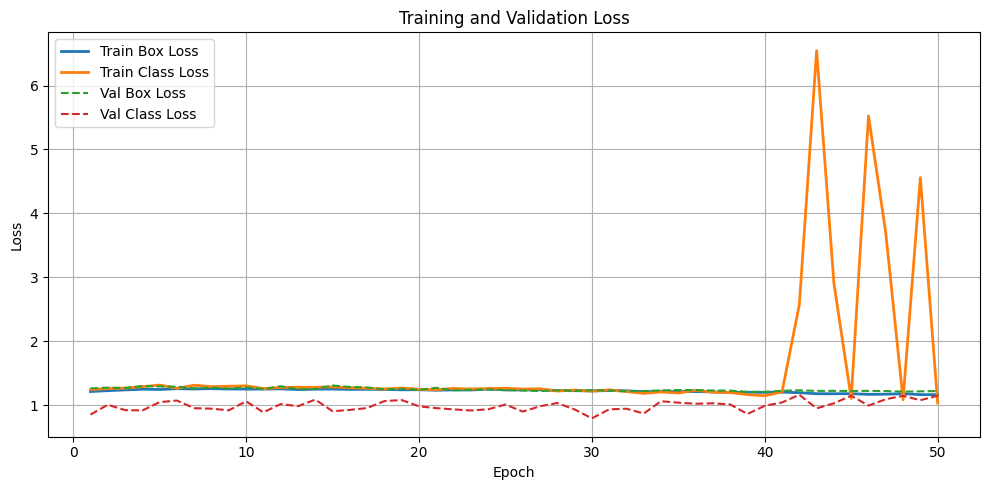

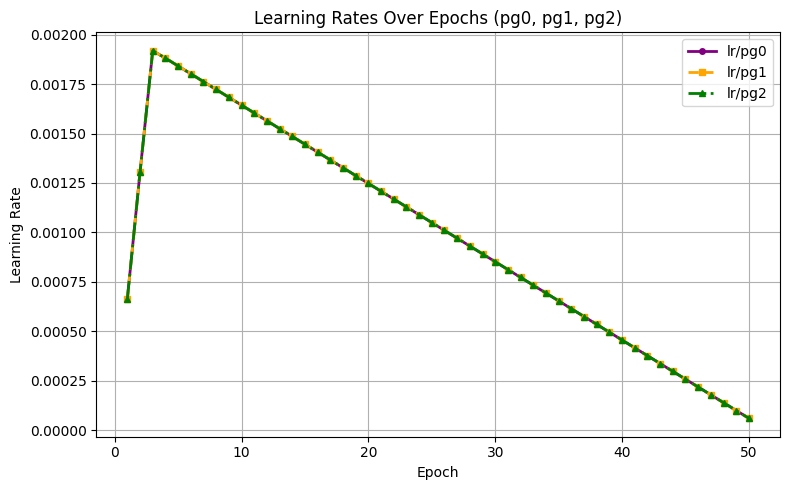

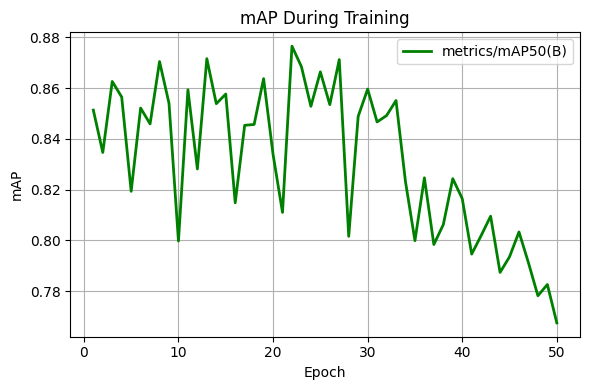

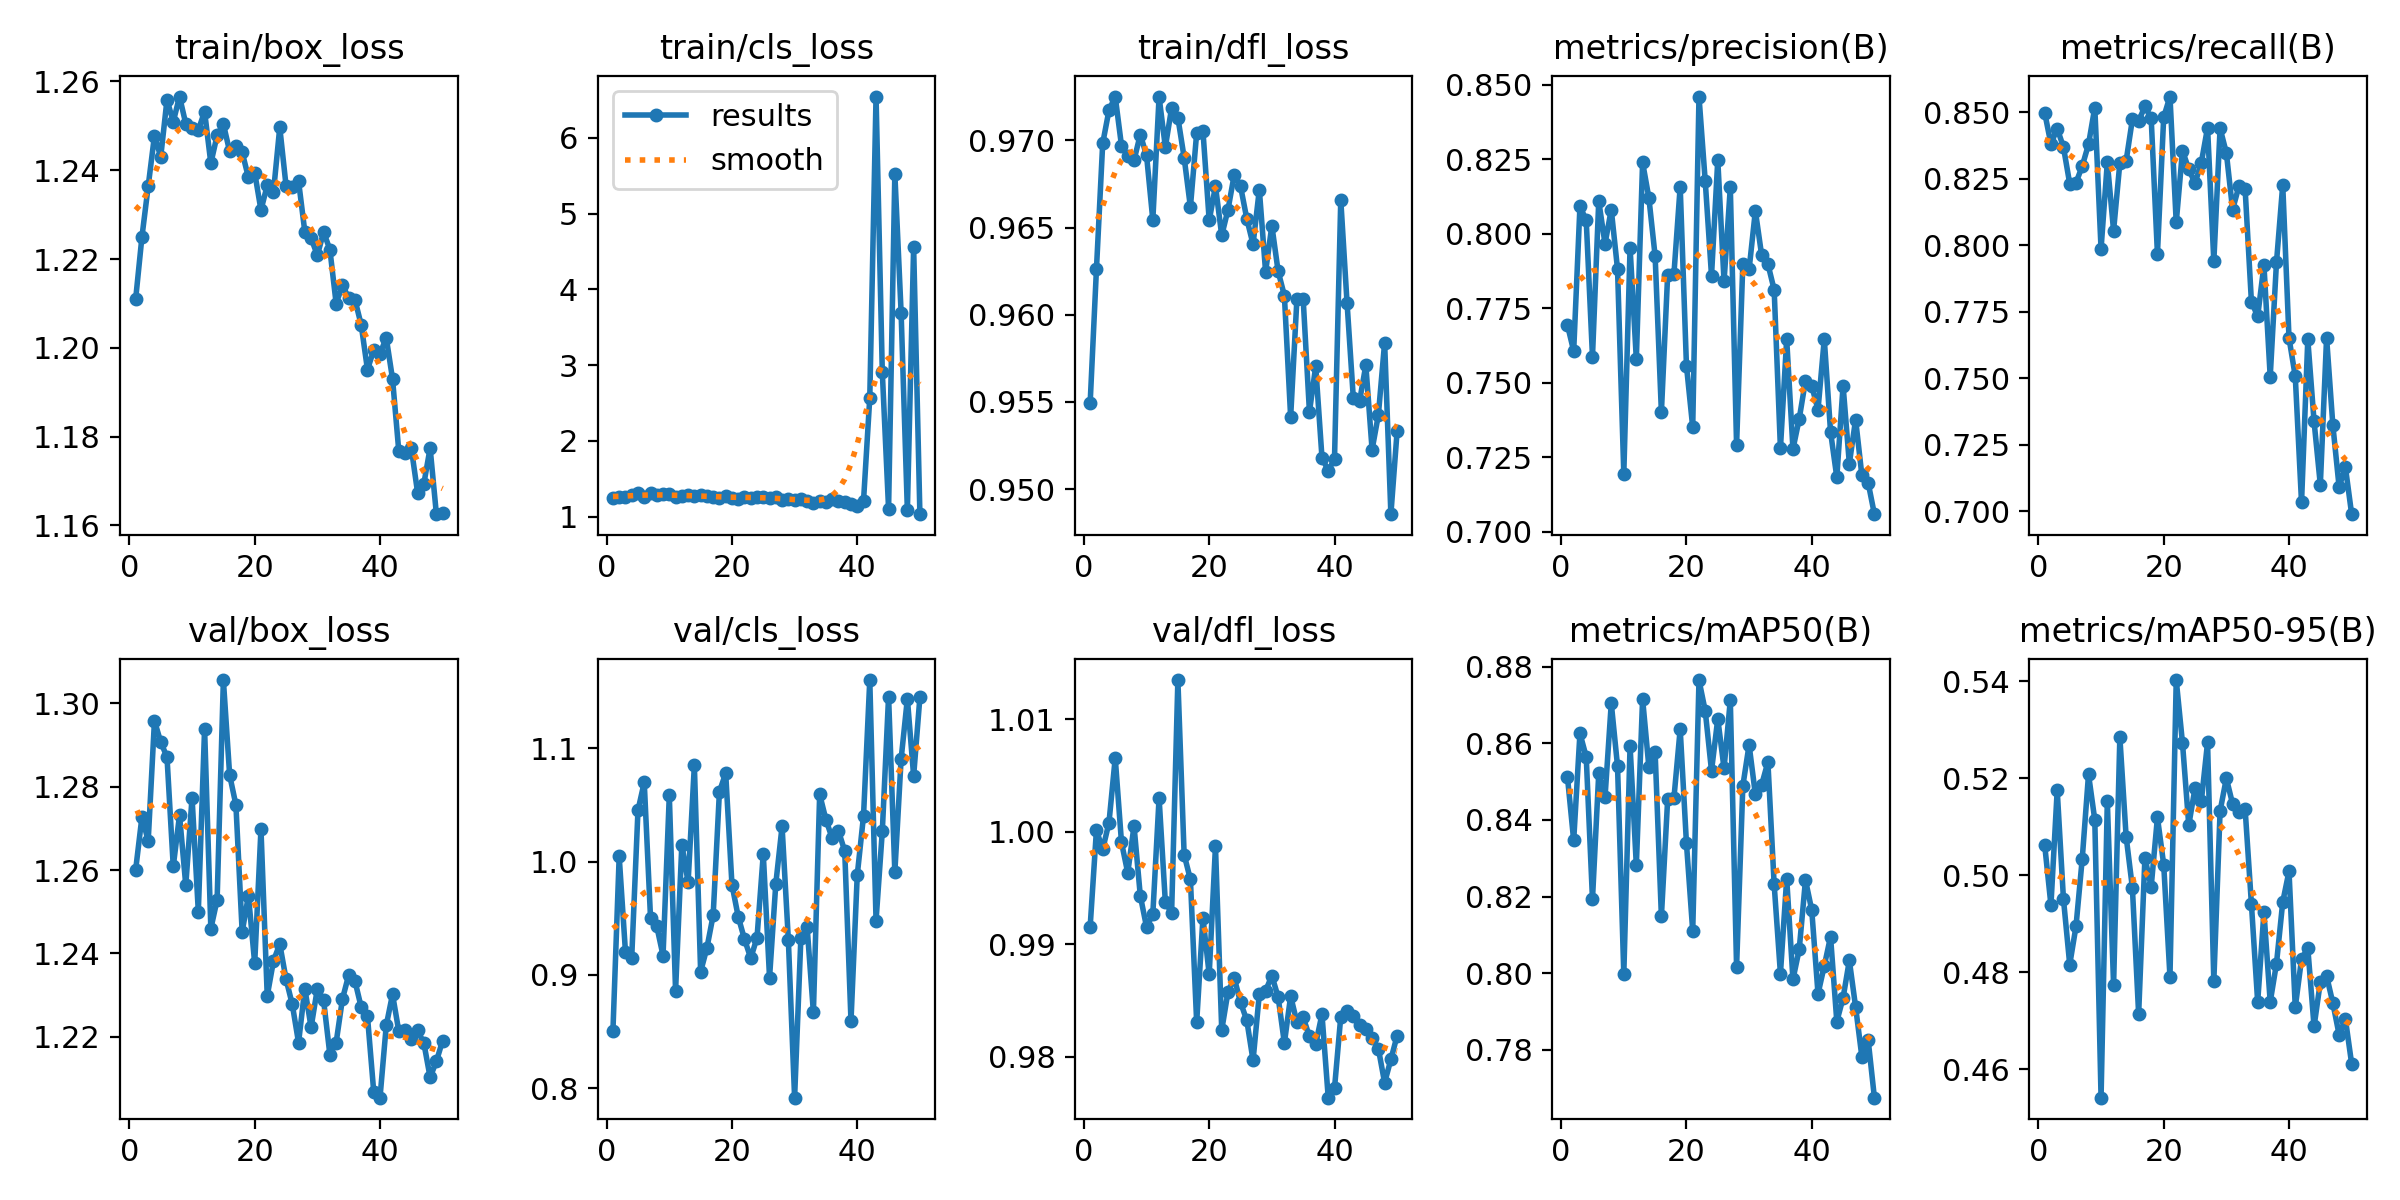

In [11]:

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path

# Path to results.csv
results_path = WORK / f"student_it{it+1}" / "results.csv"

# Load CSV
df = pd.read_csv(results_path)

# Show available columns
print("Available columns:", df.columns.tolist())

# Plot Loss Curves
plt.figure(figsize=(10, 5))
plt.plot(df["epoch"], df["train/box_loss"], label="Train Box Loss", linewidth=2)
plt.plot(df["epoch"], df["train/cls_loss"], label="Train Class Loss", linewidth=2)
plt.plot(df["epoch"], df["val/box_loss"], label="Val Box Loss", linestyle="--")
plt.plot(df["epoch"], df["val/cls_loss"], label="Val Class Loss", linestyle="--")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

lr_columns = [col for col in df.columns if col.startswith("lr/pg")]
colors = ['purple', 'orange', 'green']
styles = ['-', '--', '-.']
markers = ['o', 's', '^']

if lr_columns:
    plt.figure(figsize=(8, 5))
    for idx, col in enumerate(lr_columns):
        plt.plot(
            df["epoch"], df[col],
            label=col,
            color=colors[idx % len(colors)],
            linestyle=styles[idx % len(styles)],
            marker=markers[idx % len(markers)],
            markersize=4,
            linewidth=2
        )
    plt.xlabel("Epoch")
    plt.ylabel("Learning Rate")
    plt.title("Learning Rates Over Epochs (pg0, pg1, pg2)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
else:
    print("No learning rate columns found.")


# Plot mAP Curve (0.5 IoU)
map_keys = ["metrics/mAP50(B)", "metrics/mAP50-95(B)"]  # version dependent
map_column = next((key for key in map_keys if key in df.columns), None)

if map_column:
    plt.figure(figsize=(6, 4))
    plt.plot(df["epoch"], df[map_column], label=map_column, color="green", linewidth=2)
    plt.xlabel("Epoch")
    plt.ylabel("mAP")
    plt.title("mAP During Training")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()
else:
    print("mAP column not found. Skipping mAP plot.")



from PIL import Image
from IPython.display import display

results_img = WORK / f"student_it{it+1}" / "results.png"
img = Image.open(results_img)
display(img)

# Final Model Evaluation 

In [12]:
print("\nEvaluating …")
model   = YOLO(str(teacher_weights))
results = model.val(
    data=str(teacher_data_yaml_path),
    imgsz=640,
    batch=4,
    device=DEVICE,   # use same DEVICE string as before
    verbose=True
)

# Extract metrics depending on Ultralytics version
try:
    # new API
    metrics = results.results_dict
    print("\nValidation metrics")
    print(f"Precision (mP)   : {metrics.get('metrics/precision(B)', 0):.4f}")
    print(f"Recall (mR)      : {metrics.get('metrics/recall(B)', 0):.4f}")
    print(f"mAP@0.50         : {metrics.get('metrics/mAP50(B)', 0):.4f}")
    print(f"mAP@0.50:0.95    : {metrics.get('metrics/mAP50-95(B)', 0):.4f}")
except Exception as e:
    print("Could not parse metrics from results object:", e)
    print(results)

# import random, matplotlib.pyplot as plt

# # pick from test or valid images
# cands = list((WORK/"0_yolo_split"/"test"/"images").glob(".")) or list((WORK/"0_yolo_split"/"valid"/"images").glob("."))

# if cands:
#     imgs = random.sample(cands, min(4, len(cands)))  # pick up to 4 random images
#     fig, axes = plt.subplots(1, 4, figsize=(20, 6))
#     axes = axes.flatten()

#     for ax, img_path in zip(axes, imgs):
#         print("Visualising:", img_path.name)
#         pred = model.predict(
#             source=str(img_path),
#             imgsz=640,
#             conf=0.25,
#             device=DEVICE,
#             verbose=False
#         )[0]
#         ax.imshow(pred.plot()[:, :, ::-1])  # convert BGR to RGB
#         ax.axis("off")
#         ax.set_title(img_path.name, fontsize=10)

#     # hide unused axes if <4 images
#     for ax in axes[len(imgs):]:
#         ax.axis("off")

#     plt.tight_layout()
#     plt.show()

# else:
#     print("No images found for visualization.")


Evaluating …
Ultralytics 8.3.180 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLOv12s summary (fused): 159 layers, 9,231,267 parameters, 0 gradients, 21.2 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1629.5±300.4 MB/s, size: 82.1 KB)


val: Scanning /kaggle/working/PSEUDO_STAC/Pseudo_Converted_Dataset/labeled_val/labels.cache... 158 images, 0 backgrounds, 0 corrupt: 100%|██████████| 158/158 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 40/40 [00:04<00:00,  8.56it/s]
invalid value encountered in less
invalid value encountered in less


                   all        158      12424      0.821      0.798      0.862      0.525
Speed: 1.1ms preprocess, 21.9ms inference, 0.0ms loss, 1.2ms postprocess per image
Results saved to runs/detect/val

Validation metrics
Precision (mP)   : 0.8207
Recall (mR)      : 0.7981
mAP@0.50         : 0.8620
mAP@0.50:0.95    : 0.5253
